In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pck
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, confusion_matrix

## Funciones

In [247]:
def woe_continuas_a_discretas_train(X, numeric_columns, y, min_bins=2, max_bins=10):
    """
    Transforma columnas numéricas en categorías basadas en binning óptimo por IV
    y luego aplica WOE. Funciona con X e y separados.
    
    Parámetros:
    -----------
    X : pd.DataFrame
        Dataset de características (sin la variable objetivo).
    numeric_columns : list
        Lista de columnas numéricas a transformar.
    y : pd.Series o array-like
        Variable objetivo binaria (0 y 1).
    min_bins : int
        Número mínimo de bins a probar.
    max_bins : int
        Número máximo de bins a probar.
        
    Retorna:
    --------
    X_transformed : pd.DataFrame
        DataFrame con columnas WOE agregadas.
    woe_mapping : dict
        Diccionario con los mapeos bin → WOE por columna.
    column_bests : list
        Lista con tuplas (columna, IV óptimo, número de bins óptimo).
    bin_edges : dict
        Diccionario con los edges de bins por columna.
    """
    import numpy as np
    import pandas as pd

    if not (1 < min_bins <= max_bins):
        raise ValueError('min_bins debe ser mayor que 1 y menor o igual a max_bins')
    
    X_transformed = X.copy()
    y = pd.Series(y).reset_index(drop=True)  # Asegurar que y esté alineada
    woe_mapping = {}
    column_bests = []
    bin_edges = {}

    for col in numeric_columns:
        print(f'Procesando columna: {col}')
        best_k = 0
        best_iv = 0
        temp_woe_map = {}
        best_bin_edges = None

        for k in range(min_bins, max_bins+1):
            if X_transformed[col].nunique() < k:
                continue

            aux = pd.DataFrame({
                col: X_transformed[col],
                'target': y
            })

            try:
                aux['bin'], bin_edges_temp = pd.cut(
                    aux[col], 
                    bins=k, 
                    include_lowest=True, 
                    duplicates='drop',
                    retbins=True
                )
                aux['bin'] = aux['bin'].astype(str)
            except Exception:
                continue

            pivot_df = pd.crosstab(aux['bin'], aux['target'])
            for class_val in [0, 1]:
                if class_val not in pivot_df.columns:
                    pivot_df[class_val] = 0

            pivot_df = pivot_df[[0, 1]]
            epsilon = 1e-6
            pivot_df['prop_0'] = (pivot_df[0] + epsilon) / (pivot_df[0].sum() + 2*epsilon)
            pivot_df['prop_1'] = (pivot_df[1] + epsilon) / (pivot_df[1].sum() + 2*epsilon)

            pivot_df['WOE'] = np.log(pivot_df['prop_0'] / pivot_df['prop_1'])
            pivot_df['IV'] = (pivot_df['prop_0'] - pivot_df['prop_1']) * pivot_df['WOE']

            current_iv = pivot_df['IV'].sum()

            if not np.isinf(current_iv) and not np.isnan(current_iv):
                if current_iv > best_iv:
                    best_iv = current_iv
                    best_k = k
                    temp_woe_map = pivot_df['WOE'].to_dict()
                    best_bin_edges = bin_edges_temp

        if best_k == 0:
            print(f"  Advertencia: No se pudo encontrar un 'best_k' válido para {col}. Columna omitida.")
            continue

        print(f'{col}: Best IV = {best_iv:.4f}, Best K = {best_k}')
        column_bests.append((col, best_iv, best_k))

        X_transformed[f'{col}_bin'] = pd.cut(
            X_transformed[col], 
            bins=best_bin_edges, 
            include_lowest=True, 
            duplicates='drop'
        ).astype(str)

        X_transformed[f'W_{col}'] = X_transformed[f'{col}_bin'].map(temp_woe_map)
        X_transformed[f'W_{col}'] = X_transformed[f'W_{col}'].fillna(0)

        woe_mapping[col] = temp_woe_map
        bin_edges[col] = best_bin_edges

        X_transformed.drop(columns=[f'{col}_bin'], inplace=True)

    return X_transformed, woe_mapping, column_bests, bin_edges


In [248]:
def woe_continuas_a_discretas_test(X_test, woe_mapping, bin_edges):
    """
    Aplica la transformación WOE a un DataFrame de test usando los bins y mapeos
    aprendidos del set de entrenamiento.

    Parámetros:
    -----------
    X_test : pd.DataFrame
        Dataset de características (sin la variable objetivo).
    woe_mapping : dict
        Diccionario con mapeos bin → WOE por columna (salida del train).
    bin_edges : dict
        Diccionario con los edges de los bins por columna (salida del train).

    Retorna:
    --------
    X_transformed : pd.DataFrame
        Dataset de test con las columnas WOE agregadas.
    """
    import pandas as pd

    X_transformed = X_test.copy()

    for col in woe_mapping.keys():
        print(f'Transformando columna: {col}')
        try:
            # Usar los MISMOS edges que en train
            X_transformed[f'{col}_bin'] = pd.cut(
                X_transformed[col],
                bins=bin_edges[col],
                include_lowest=True,
                duplicates='drop'
            ).astype(str)

            # Mapear con WOE ya aprendido
            X_transformed[f'W_{col}'] = X_transformed[f'{col}_bin'].map(woe_mapping[col])

            # Llenar NaNs si aparece un bin que no existía en train
            X_transformed[f'W_{col}'] = X_transformed[f'W_{col}'].fillna(0)

            # Eliminar columna temporal bin
            X_transformed.drop(columns=[f'{col}_bin'], inplace=True)

        except Exception as e:
            print(f'Error transformando {col}: {e}')

    return X_transformed


## Analisis de datos

In [125]:
summ = pd.read_csv('datos/summary.csv')

In [126]:
summ

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness
0,TRJPTGQ128F42A2187,SOIYHHS12A8C13E7B5,0.452,0.000,0.556,0.0,2007,141.66159,1.000,Don't Cry,141.662,22050,4,103.085,ARJ5FD21187FB43F12,Mavado,0.520784,0,Gangsta For Life: The Symphony Of David Brooks,-5.816
1,TRZWFET128F425BF9E,SONEJET12A8C137D3E,0.669,0.000,0.679,0.0,2005,354.69016,0.529,Gypsy Funeral: Hark! From The Tombs Of Doleful...,348.253,22050,1,123.153,ARH3CTU1187FB365C7,Miasma & The Carousel Of Headless Horses,0.346908,9,Perils,-11.137
2,TRNTAMF128F14618CA,SOPAGVA12AF729F018,0.551,0.000,0.672,0.0,2001,338.44200,1.000,Trade Money,327.529,22050,4,162.540,AR0CANF1187B9AF35F,Dilated Peoples,0.457841,7,Expansion Team,-5.199
3,TRALQGQ128F427E682,SODZLJT12A8C13BD4C,0.354,0.000,0.378,0.0,2004,202.37016,1.000,Me Han Vuelto Loca,200.220,22050,4,101.978,ARKE6XC1187B991839,Merche,0.406329,6,Autentica,-2.756
4,TRLOUXS128F92D963F,SOXWPNT12AAF3B270E,0.761,0.000,0.615,0.0,2005,315.58485,0.719,Riders On The Storm,288.142,22050,4,108.992,AR2TT8P1187B9B624D,O'2L,0.291499,9,Doyle's Brunch,-8.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,TRGWRQD128F4298D89,SOMYXHV12A8C13BA11,0.355,0.496,0.032,0.0,1998,209.16200,0.260,arm (Album Version),206.495,22050,4,90.024,AR4CO001187FB4731E,the feelers,0.486442,11,Supersystem,-6.153
19996,TRIPSRA128F931DBAA,SOHOYEM12AB017F833,0.407,0.000,0.353,0.0,2007,90.95791,0.000,Raw Diamond,90.958,22050,4,165.282,ARVRTDI1187B99D797,Baby Grandmothers,0.343689,0,Baby Grandmothers,-5.540
19997,TRSYCMI12903CE007B,SOYSKTB12A58A7B126,0.526,0.000,0.730,0.0,2005,154.67057,0.542,Boom Boom Boom East Blues,154.671,22050,4,190.921,ARCWZP81187FB40E42,Hillstomp,0.425443,2,The Woman That Ended The World,-8.800
19998,TRKVYMQ128F9303EB5,SODWMOZ12A8C13D1CE,0.409,2.682,0.749,0.0,2001,191.29424,0.767,Serenata,177.308,22050,5,139.339,ARJMB691187FB54124,Luciano Pavarotti,0.496486,7,A Song to Remember,-17.083


In [127]:
len(summ['energy'].value_counts())

1

In [128]:
summ['energy'].value_counts()

energy
0.0    20000
Name: count, dtype: int64

In [129]:
aud_feat = pd.read_csv('datos/audio_features.csv')

In [130]:
pd.set_option('display.max_columns', None)
aud_feat

,analysis_sample_rate,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,codec,downmix,md5_encoded,track_id,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness
0,44100,128056,0,60.081612,0,-14.896189,22050,mp3,mix,9b2010d602420c02fd513c4bd79f0e1a,TRLCHOG12903CBE201,0.728646,0.616806,2.266771e-09,0.999996,0.075123,0.683977,0.510561,0.103477,0.004121,0.217572,0.294421,0.002060
1,44100,128056,0,60.029366,0,-4.654913,22050,mp3,mix,b8130f7ef3c9b28b43718311a851401f,TREQXBJ128F934E3CE,0.017633,0.752542,9.705600e-01,0.000016,0.173669,0.044266,0.002073,0.990112,0.976110,0.394722,0.994963,0.996827
2,44100,128056,0,60.081612,0,-8.621744,22050,mp3,mix,58f66795976e8a247cfc7b236df8ecfa,TRGRCXR12903CFD7CD,0.167005,0.073315,9.027991e-01,0.116882,0.156126,0.461002,0.079624,0.635178,0.797037,0.962334,0.921192,0.001401
3,44100,128000,0,60.081635,0,-9.171843,44100,mp3,mix,cfeec8a419264b103f2b081527d3c2da,TRTOZPV128F92D71AC,0.694412,0.003315,4.715616e-01,0.034741,0.532327,0.500000,0.298832,0.218486,0.653770,0.456679,0.970731,0.012652
4,44100,128111,0,30.040817,0,-9.060616,44100,mp3,mix,7add0fbccf6ff22900efeeb9ead8a59d,TRKNISH128F42627EA,0.226367,0.717184,3.517592e-02,0.682841,0.190215,0.651303,0.684198,0.255997,0.102924,0.248094,0.973870,0.383030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19659,44100,128111,0,30.040817,0,-7.517710,44100,mp3,mix,3b0a7503ed792e5d778893923bfa6804,TRDPAJY128F92FC55C,0.168015,0.987025,3.540825e-01,0.055762,0.635024,0.355624,0.291486,0.760798,0.519728,0.965883,0.913866,0.026887
19660,44100,128111,0,30.090929,0,-13.033228,22050,mp3,mix,b18aade4d623eb271e41ebab049a2efe,TRLMMXC128E0788922,0.163524,0.640598,8.652153e-03,0.162394,0.306545,0.318722,0.167853,0.536974,0.337150,0.573431,0.829188,0.507271
19661,44100,128111,0,30.040817,0,-16.879805,44100,mp3,mix,635579dc324625ee909593a8c4591a5d,TRUPXCC12903CC4E16,0.945337,0.023581,3.361252e-02,0.921268,0.229842,0.543545,0.678771,0.031759,0.065743,0.679156,0.679754,0.000847
19662,44100,128056,0,60.081612,0,-12.494322,22050,mp3,mix,339dec54456a68db26f9b962c69c08d4,TRQVIJY12903CB6BED,0.117992,0.849533,8.022478e-01,0.018567,0.232288,0.164193,0.063216,0.974034,0.728285,0.249303,0.549528,0.007322


In [131]:
summ[summ['track_id'] == 'TRAVDUU128F424D590']

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness
3088,TRAVDUU128F424D590,SOCOHKB12A6D4FD6A1,0.634,0.311,0.736,0.0,2008,264.93342,0.334,Voiman vartijat,264.933,22050,3,181.992,ARW4CA41187FB3F152,Ter\xc3\xa4sbetoni,0.420238,11,Myrskyntuoja,-2.302


In [132]:
aud_feat.isnull().sum()

analysis_sample_rate    0
bit_rate                0
equal_loudness          0
length                  0
lossless                0
replay_gain             0
sample_rate             0
codec                   0
downmix                 0
md5_encoded             0
track_id                0
danceability            0
femaleness              0
acousticness            0
aggressiveness          0
electronicity           0
happiness               0
festiveness             0
relaxation              0
sadness                 0
brightness              0
tonality                0
insrumentalness         0
dtype: int64

In [133]:
len(aud_feat['danceability'].value_counts())

19135

In [134]:
len(aud_feat['happiness'].value_counts())

19429

In [135]:
len(aud_feat['festiveness'].value_counts())

19464

In [136]:
len(aud_feat['relaxation'].value_counts())

19449

In [137]:
len(aud_feat['sadness'].value_counts())

19531

In [138]:
summ[summ['artist_hotttnesss'] == summ['artist_hotttnesss'].max()]

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness
9183,TRORZPX128F42ACE6B,SOKBRVC12A81C204DE,0.751,0.083,0.784,0.0,2007,313.28608,1.000,Drunk and Hot Girls,308.558,22050,3,165.558,ARRH63Y1187FB47783,Kanye West / Mos Def,1.082503,10,Graduation,-7.742
13831,TRDJSBZ128E0791597,SOKXNNH12A67020A46,0.512,0.063,0.532,0.0,2009,448.05179,0.795,We Major,448.052,22050,4,99.314,ARRH63Y1187FB47783,Kanye West / Nas / Really Doe,1.082503,11,Late Registration,-4.313
16104,TRPBGJR128F92FA7FE,SOPIJAI12AB01838F8,0.706,0.000,1.000,0.0,2008,262.92200,0.954,Welcome To Heartbreak,259.030,22050,4,192.029,ARRH63Y1187FB47783,Kanye West / Kid Cudi,1.082503,7,808s & Heartbreak,-12.208


In [139]:
df =  pd.merge(summ, aud_feat, on = 'track_id', how  = 'outer')

In [140]:
df.isna().sum()

track_id                        0
song_id                      2556
mode_confidence              2556
end_of_fade_in               2556
key_confidence               2556
energy                       2556
year                         2556
duration                     2556
time_signature_confidence    2556
title                        2556
start_of_fade_out            2556
analysis_sample_rate_x       2556
time_signature               2556
tempo                        2556
artist_id                    2556
artist_name                  2556
artist_hotttnesss            2556
key                          2556
release                      2556
loudness                     2556
analysis_sample_rate_y       2892
bit_rate                     2892
equal_loudness               2892
length                       2892
lossless                     2892
replay_gain                  2892
sample_rate                  2892
codec                        2892
downmix                      2892
md5_encoded   

In [141]:
song_play_count = pd.read_csv('datos/song_play_count.csv')

In [142]:
song_play_count

,user_id,song_id,play_count
0,60187,SOYMXMF12A6D4FCDA2,1
1,11193,SOIYNJG12AB01810B2,2
2,67953,SOYDTRQ12AF72A3D61,5
3,132173,SOLGFKA12A6D4F7B9A,1
4,578451,SOTDPWU12A8AE47B2B,4
...,...,...,...
1517636,129566,SOIPSLZ12A8C140561,1
1517637,101507,SOCIDVO12A58A7DDA4,2
1517638,573589,SOGXDRM12A6D4F7CE0,1
1517639,469534,SOIDDNJ12AC9071B90,1


In [143]:
df_trgt = song_play_count.groupby('song_id')['play_count'].sum()

In [144]:
df_trgt

song_id
SOAABDH12A6D4F7658       9
SOAAGDJ12A8C13A1C6     661
SOAAGQU12AB01843A8       1
SOAALEG12A58A79808     282
SOAAMTH12AF729D4E5    1021
                      ... 
SOZZTQU12AB017FAEE     159
SOZZWHT12A8C142264     125
SOZZXQJ12AB0184460       4
SOZZYDH12AAF3B31AF       7
SOZZZHR12A8C138D52       9
Name: play_count, Length: 10370, dtype: int64

In [145]:
df_trgt = df_trgt.reset_index()

In [146]:
df_trgt

,song_id,play_count
0,SOAABDH12A6D4F7658,9
1,SOAAGDJ12A8C13A1C6,661
2,SOAAGQU12AB01843A8,1
3,SOAALEG12A58A79808,282
4,SOAAMTH12AF729D4E5,1021
...,...,...
10365,SOZZTQU12AB017FAEE,159
10366,SOZZWHT12A8C142264,125
10367,SOZZXQJ12AB0184460,4
10368,SOZZYDH12AAF3B31AF,7


In [147]:
df = pd.merge(df, df_trgt, on = 'song_id', how = 'outer')

In [148]:
df.isnull().sum()

track_id                         0
song_id                       2556
mode_confidence               2556
end_of_fade_in                2556
key_confidence                2556
energy                        2556
year                          2556
duration                      2556
time_signature_confidence     2556
title                         2556
start_of_fade_out             2556
analysis_sample_rate_x        2556
time_signature                2556
tempo                         2556
artist_id                     2556
artist_name                   2556
artist_hotttnesss             2556
key                           2556
release                       2556
loudness                      2556
analysis_sample_rate_y        2892
bit_rate                      2892
equal_loudness                2892
length                        2892
lossless                      2892
replay_gain                   2892
sample_rate                   2892
codec                         2892
downmix             

In [149]:
df

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate_x,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness,analysis_sample_rate_y,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,codec,downmix,md5_encoded,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count
0,TRMTWOF128F147EA43,SOAABDH12A6D4F7658,0.893,0.277,0.830,0.0,1999.0,215.14404,0.299,Prefiero,206.002,22050.0,4.0,205.734,AR8EDG51187FB41A08,Gary Hobbs,0.389766,7.0,Despues De Ti,-9.103,44100.0,64057.0,0.0,60.029366,0.0,-10.189594,22050.0,mp3,mix,5bfeb8b1e95729e6511e029d17ca052d,0.418873,0.635057,3.821953e-01,0.066103,0.142944,0.795350,0.321348,0.544195,0.645960,0.969493,0.972927,0.019999,9.0
1,TRTKIPU128F4295E86,SOAACBD12A8C13C8C4,0.986,5.846,0.892,0.0,2004.0,292.70159,0.469,Schutz\xc3\xa4ngel,280.602,22050.0,4.0,86.842,ARPEHXU1187FB459BF,Pl\xc3\xbcsch,0.342917,2.0,Sidefiin,-11.591,44100.0,128111.0,0.0,30.040817,0.0,-8.736227,44100.0,mp3,mix,aba0901be553865b01971b194d75aabf,0.470389,0.698749,9.649308e-01,0.025333,0.012969,0.453471,0.029834,0.990617,0.977490,0.974045,0.994053,0.000029,NaN
2,TRXDLKB128F14A0D37,SOAACTO12A6D4FBC75,0.612,0.000,0.607,0.0,1997.0,419.05587,0.360,Shelter,414.465,22050.0,4.0,139.998,ARXONP51187B9AF54A,Mijk Van Dijk,0.393413,1.0,Shelter,-6.768,44100.0,64109.0,0.0,30.014671,0.0,-12.918201,22050.0,mp3,mix,da9dac82d4f714fdf985f26745b8d838,0.519934,0.764675,2.732940e-03,0.466219,0.969136,0.309143,0.838269,0.053038,0.023681,0.664507,0.011120,0.025571,NaN
3,TRLNIIK12903CD040B,SOAADJB12AB0188C24,0.614,0.259,0.885,0.0,1999.0,241.47546,0.000,The One,234.760,22050.0,4.0,127.990,ARRRYGH1187B9B9FE8,Den Harrow,0.395906,11.0,Back From The Future,-6.785,44100.0,128056.0,0.0,60.081612,0.0,-12.370787,22050.0,mp3,mix,0321141e3273f24acef6b733499f1c0f,0.994743,0.923131,1.270489e-02,0.442953,0.821824,0.776063,0.881728,0.073152,0.168183,0.994569,0.826780,0.061254,NaN
4,TRSOAAB128F1498895,SOAAFWR12A6D4F92C1,0.535,0.567,0.423,0.0,2003.0,298.13506,0.537,Come Rain Or Come Shine,285.733,22050.0,3.0,82.071,ARCN61O1187B9ABBE8,Aaron Neville,0.508938,0.0,Nature Boy: The Standards Album,-16.675,44100.0,128000.0,0.0,30.040817,0.0,-6.271719,44100.0,mp3,mix,9aacb42eaadd459de6b346619ba542c7,0.063820,0.077110,9.667940e-01,0.000014,0.156449,0.046899,0.040868,0.981551,0.811426,0.864642,0.941787,0.871637,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,TRZYLMO128EF354C98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,64055.0,0.0,30.040794,0.0,-9.742807,22050.0,mp3,mix,1101a81e46f4bf30f8ff47486284711b,0.998895,0.881488,2.941813e-03,0.826598,0.993948,0.794935,0.832598,0.101857,0.084123,0.026319,0.249012,0.182163,NaN
22552,TRZYQAI128F9329FFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.029366,0.0,-12.194342,22050.0,mp3,mix,12ae1fb352fb0e14005bf9da07790d6c,0.597751,0.170400,2.953405e-03,0.896917,0.917529,0.105743,0.894987,0.301557,0.211276,0.004390,0.288906,0.308543,NaN
22553,TRZZVQO12903CA7F34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.081612,0.0,-12.197174,22050.0,mp3,mix,f1793679f69c649b3ce4f3744d894668,0.877739,0.220075,3.969250e-01,0.002929,0.072631,0.934857,0.191097,0.180074,0.457773,0.905693,0.811138,0.039957,NaN
22554,TRZZXUC12903CF8108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.081612,0.0,-14.950634,22050.0,mp3,mix,bdf901299b096d8f427d491956e9f842,0.735522,0.276195,1.275369e-01,0.191142,0.021233,0.903582,0.373696,0.161387,0.160291,0.990295,0.364201,0.939390,NaN


In [150]:
song_genres = pd.read_csv('datos/song_genres.csv')

In [151]:
song_genres

,track_id,main_genre
0,TRSZBVQ128F425D5B6,Rock
1,TRRJNCE128F9319E52,RnB
2,TRIZJQX128F1472163,Folk
3,TRBXBWB128F92F9F2B,Rap
4,TRFBZFH12903CBDABB,Electronic
...,...,...
8411,TRHKNDN128F9320924,Blues
8412,TRGIYIR128F92DCDF1,Rock
8413,TRVFMDX128F42915F2,Punk
8414,TRLWOAY128F933A6A3,Rock


In [152]:
df = pd.merge(df, song_genres, how = 'outer', on = 'track_id')

In [153]:
df.isnull().sum()

track_id                         0
song_id                       4965
mode_confidence               4965
end_of_fade_in                4965
key_confidence                4965
energy                        4965
year                          4965
duration                      4965
time_signature_confidence     4965
title                         4965
start_of_fade_out             4965
analysis_sample_rate_x        4965
time_signature                4965
tempo                         4965
artist_id                     4965
artist_name                   4965
artist_hotttnesss             4965
key                           4965
release                       4965
loudness                      4965
analysis_sample_rate_y        5301
bit_rate                      5301
equal_loudness                5301
length                        5301
lossless                      5301
replay_gain                   5301
sample_rate                   5301
codec                         5301
downmix             

In [154]:
df

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate_x,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness,analysis_sample_rate_y,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,codec,downmix,md5_encoded,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,SOHUOAP12A8AE488E9,0.829,0.000,1.000,0.0,1987.0,491.12771,0.756,Floating,486.034,22050.0,4.0,119.826,ARD842G1187B997376,Blue Rodeo,0.447935,7.0,Outskirts,-8.576,44100.0,128100.0,0.0,33.306122,0.0,-15.267794,44100.0,mp3,mix,7a2ebe6667028eec15458c0c04de2714,0.320790,0.024384,9.004630e-01,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
1,TRAABWE128F93418C0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.029366,0.0,-15.162943,22050.0,mp3,mix,a30730ce15a8f97e893dbd359b51b8ed,0.984246,0.643747,2.006704e-06,0.999608,0.980326,0.059469,0.975727,0.032910,0.004847,0.003837,0.008125,0.036147,NaN,NaN
2,TRAACNS128F14A2DF5,SOBZBAZ12A6D4F8742,0.736,0.200,0.812,0.0,1997.0,168.25424,0.792,Spanish Grease,161.890,22050.0,4.0,127.025,AROUOZZ1187B9ABE51,Willie Bobo,0.379671,8.0,Willie Bobo's Finest Hour,-9.616,44100.0,64028.0,0.0,60.029366,0.0,-9.773314,22050.0,mp3,mix,b1e279a0dc927cd5b5dff28de6b6d2df,0.618978,0.942064,6.634281e-01,0.046902,0.640927,0.457956,0.288112,0.776293,0.813896,0.949835,0.974706,0.188617,NaN,NaN
3,TRAACPE128F421C1B9,SOGNCJP12A58A80271,0.538,0.063,0.381,0.0,1972.0,342.56934,0.353,Do You Finally Need A Friend,333.154,22050.0,3.0,110.189,ARB29H41187B98F0EF,Terry Callier,0.416173,6.0,Occasional Rain,-11.939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RnB
4,TRAACTB12903CAAF15,SOGXHEG12AB018653E,0.402,0.000,0.384,0.0,1992.0,133.32853,0.000,It Makes No Difference Now,130.009,22050.0,1.0,160.839,AR0RCMP1187FB3F427,Billie Jo Spears,0.384611,4.0,20 Of Her Best,-9.983,44100.0,128056.0,0.0,60.029366,0.0,-11.237694,22050.0,mp3,mix,39731fa10f282a2150e5e70506a61215,0.235422,0.954638,1.852035e-01,0.000013,0.071714,0.815497,0.233605,0.410173,0.723580,0.902474,0.954868,0.260661,NaN,Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24960,TRZZXUC12903CF8108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.081612,0.0,-14.950634,22050.0,mp3,mix,bdf901299b096d8f427d491956e9f842,0.735522,0.276195,1.275369e-01,0.191142,0.021233,0.903582,0.373696,0.161387,0.160291,0.990295,0.364201,0.939390,NaN,NaN
24961,TRZZYOF128F4255016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Age
24962,TRZZZFV128F4259A2B,SOXJZLK12A8AE48D05,0.293,0.955,0.037,0.0,2000.0,297.58649,0.294,Kill All Hippies,294.383,22050.0,5.0,66.394,ARW63XP1187FB5AB99,Primal Scream,0.488099,5.0,XTRMNTR,-6.329,44100.0,128111.0,0.0,30.040817,0.0,-10.148268,44100.0,mp3,mix,2ad6f8fe1e81b081aa365db3f10c9dd2,0.552813,0.766357,2.436607e-02,0.904225,0.665552,0.282454,0.868709,0.029786,0.089039,0.856844,0.725524,0.423473,155.0,NaN
24963,TRZZZQO128E078864C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,64055.0,0.0,30.066916,0.0,-13.374027,22050.0,mp3,mix,dac4488591d80af59b85a2d9ed4ab608,0.574547,0.450648,5.777591e-07,0.987771,0.814584,0.546908,0.764537,0.082487,0.006817,0.135821,0.234135,0.003976,NaN,NaN


In [155]:
df_mer = df.dropna()

In [156]:
df_mer.isnull().sum()

track_id                     0
song_id                      0
mode_confidence              0
end_of_fade_in               0
key_confidence               0
energy                       0
year                         0
duration                     0
time_signature_confidence    0
title                        0
start_of_fade_out            0
analysis_sample_rate_x       0
time_signature               0
tempo                        0
artist_id                    0
artist_name                  0
artist_hotttnesss            0
key                          0
release                      0
loudness                     0
analysis_sample_rate_y       0
bit_rate                     0
equal_loudness               0
length                       0
lossless                     0
replay_gain                  0
sample_rate                  0
codec                        0
downmix                      0
md5_encoded                  0
danceability                 0
femaleness                   0
acoustic

In [157]:
df_mer.describe([0.01, 0.25, 0.5, 0.75, 0.99])

,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,start_of_fade_out,analysis_sample_rate_x,time_signature,tempo,artist_hotttnesss,key,loudness,analysis_sample_rate_y,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count
count,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.0,3330.000000,3330.0,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3.330000e+03,3.330000e+03,3330.000000,3330.000000,3330.000000,3.330000e+03,3330.000000,3330.000000
mean,0.471971,0.911983,0.439054,0.0,1999.593093,250.537805,0.527278,240.870660,22050.0,3.663363,125.800729,0.456388,5.279880,-8.953480,44100.0,108075.679580,0.0,46.855027,0.0,-11.358983,29023.153153,4.416050e-01,5.431135e-01,2.743777e-01,4.008949e-01,0.494576,4.660381e-01,4.225352e-01,0.455529,0.349852,0.589916,5.363020e-01,0.246328,467.716817
std,0.191614,2.205328,0.276908,0.0,9.782274,103.604439,0.371293,101.263597,0.0,1.119964,34.270209,0.095505,3.588438,4.577903,0.0,29865.628926,0.0,15.614642,0.0,3.570724,10254.412188,3.834576e-01,3.203668e-01,3.415280e-01,3.808397e-01,0.314047,2.817952e-01,3.019056e-01,0.361275,0.303856,0.361049,3.738967e-01,0.340768,1878.904170
min,0.000000,0.000000,0.000000,0.0,1930.000000,14.863220,0.000000,14.863000,22050.0,0.000000,0.000000,0.000000,0.000000,-41.752000,44100.0,58145.000000,0.0,8.672630,0.0,-20.352661,22050.000000,3.000001e-14,7.190201e-11,4.062316e-12,3.000001e-14,0.000013,6.147993e-10,2.580266e-07,0.000736,0.001810,0.000093,3.000001e-14,0.000002,1.000000
1%,0.000000,0.000000,0.000000,0.0,1968.000000,56.437095,0.000000,54.930080,22050.0,1.000000,50.147350,0.286320,0.000000,-24.349580,44100.0,64028.000000,0.0,29.884060,0.0,-16.897257,22050.000000,7.899662e-11,4.387197e-03,1.136856e-08,4.724511e-07,0.017470,5.149552e-03,1.316717e-03,0.004189,0.006606,0.002551,1.054249e-07,0.000054,1.000000
25%,0.356250,0.000000,0.204250,0.0,1996.000000,192.339142,0.148000,183.131250,22050.0,4.000000,99.973250,0.396474,2.000000,-11.149500,44100.0,64058.000000,0.0,30.040817,0.0,-13.891028,22050.000000,5.275831e-02,2.570719e-01,8.052085e-03,4.297031e-02,0.200964,2.218598e-01,1.287067e-01,0.091735,0.078084,0.223513,1.369093e-01,0.005410,17.000000
50%,0.479000,0.200000,0.455000,0.0,2003.000000,235.336690,0.578500,225.010000,22050.0,4.000000,123.690500,0.447056,5.000000,-7.913000,44100.0,128056.000000,0.0,60.029366,0.0,-12.122363,22050.000000,3.522282e-01,5.613017e-01,7.974853e-02,2.535777e-01,0.476828,4.547744e-01,4.126302e-01,0.390139,0.246993,0.688222,5.904834e-01,0.051168,64.000000
75%,0.600000,0.453000,0.648000,0.0,2006.000000,290.298325,0.879000,278.027250,22050.0,4.000000,147.201500,0.509863,9.000000,-5.659000,44100.0,128111.000000,0.0,60.029366,0.0,-9.572178,44100.000000,8.640895e-01,8.542334e-01,5.107173e-01,8.175596e-01,0.790406,7.047899e-01,6.879548e-01,0.829054,0.605832,0.947904,9.164003e-01,0.405115,251.750000
99%,0.904130,9.202540,1.000000,0.0,2010.000000,559.813818,1.000000,542.902030,22050.0,7.000000,216.406170,0.768767,11.000000,-2.692060,44100.0,128111.000000,0.0,60.133854,0.0,-0.689969,44100.000000,9.999987e-01,9.991403e-01,9.947895e-01,9.999409e-01,0.996431,9.884020e-01,9.658494e-01,0.996411,0.965459,1.000000,9.990849e-01,0.999998,7084.890000
max,1.000000,60.511000,1.000000,0.0,2010.000000,1686.569340,1.000000,1677.125000,22050.0,7.000000,248.441000,1.082503,11.000000,0.709000,44100.0,230322.000000,0.0,310.256317,0.0,38.401222,44100.000000,9.999999e-01,9.999861e-01,9.999401e-01,9.999999e-01,0.999930,9.999999e-01,9.999960e-01,0.999999,0.992247,1.000000,9.999726e-01,1.000000,49119.000000


#### Variables que no sirven: Variables con std = 0, year, codec, downmix, md5_encoded

In [158]:
df_mer['bit_rate'].value_counts()

bit_rate
128056.0    1001
128111.0     978
64028.0      428
64055.0      280
128000.0     258
            ... 
64068.0        1
64115.0        1
128086.0       1
64118.0        1
128062.0       1
Name: count, Length: 77, dtype: int64

In [159]:
df_mer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 24947
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   track_id                   3330 non-null   object 
 1   song_id                    3330 non-null   object 
 2   mode_confidence            3330 non-null   float64
 3   end_of_fade_in             3330 non-null   float64
 4   key_confidence             3330 non-null   float64
 5   energy                     3330 non-null   float64
 6   year                       3330 non-null   float64
 7   duration                   3330 non-null   float64
 8   time_signature_confidence  3330 non-null   float64
 9   title                      3330 non-null   object 
 10  start_of_fade_out          3330 non-null   float64
 11  analysis_sample_rate_x     3330 non-null   float64
 12  time_signature             3330 non-null   float64
 13  tempo                      3330 non-null   float64
 

In [160]:
lst_cont = df_mer.select_dtypes(include = ['float64']).columns

In [161]:
lst_cont

Index(['mode_confidence', 'end_of_fade_in', 'key_confidence', 'energy', 'year',
       'duration', 'time_signature_confidence', 'start_of_fade_out',
       'analysis_sample_rate_x', 'time_signature', 'tempo',
       'artist_hotttnesss', 'key', 'loudness', 'analysis_sample_rate_y',
       'bit_rate', 'equal_loudness', 'length', 'lossless', 'replay_gain',
       'sample_rate', 'danceability', 'femaleness', 'acousticness',
       'aggressiveness', 'electronicity', 'happiness', 'festiveness',
       'relaxation', 'sadness', 'brightness', 'tonality', 'insrumentalness',
       'play_count'],
      dtype='object')

In [162]:
lst_std_z = df_mer[lst_cont].columns[df_mer[lst_cont].std() == 0]

In [163]:
lst_std_z

Index(['energy', 'analysis_sample_rate_x', 'analysis_sample_rate_y',
       'equal_loudness', 'lossless'],
      dtype='object')

In [164]:
df_mer = df_mer.drop(columns = lst_std_z)

In [165]:
df_mer

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,year,duration,time_signature_confidence,title,start_of_fade_out,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness,bit_rate,length,replay_gain,sample_rate,codec,downmix,md5_encoded,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,SOHUOAP12A8AE488E9,0.829,0.000,1.000,1987.0,491.12771,0.756,Floating,486.034,4.0,119.826,ARD842G1187B997376,Blue Rodeo,0.447935,7.0,Outskirts,-8.576,128100.0,33.306122,-15.267794,44100.0,mp3,mix,7a2ebe6667028eec15458c0c04de2714,3.207898e-01,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
7,TRAAEHK128F92C9C79,SOXQUAN12A8C14237B,0.360,0.000,0.328,2000.0,212.74077,0.424,Big Boy Now,204.516,4.0,166.349,ARXDGV71187B990B08,Super Chikan,0.000000,10.0,What You See,-6.469,128056.0,60.029366,-13.997978,22050.0,mp3,mix,21b83200664e09975adc157a1e148870,7.771334e-01,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,15.0,Blues
8,TRAAFOH128E078BD7E,SOMJOMF12A6701DDCA,0.472,1.570,0.365,2004.0,221.98812,0.600,Sold,208.747,4.0,210.102,AR9SWNW1187FB5934B,Imperanon,0.417325,0.0,Stained,-5.040,128111.0,30.040817,-13.311316,44100.0,mp3,mix,d840e9ee93793271850bdc12e6c3f39f,2.643282e-03,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,40.0,Metal
11,TRAAIMO128F92EB778,SOREAWH12AB017BF03,0.554,0.549,0.460,2009.0,209.34485,0.690,Ain't No Secret,199.343,4.0,109.003,ARBTDXS11E2835CEC6,The Alternate Routes,0.427150,0.0,A Sucker's Dream,-4.851,128111.0,30.040794,-14.724085,22050.0,mp3,mix,fa91596b57edf4b84fe2a73395f77daf,1.223387e-01,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,68.0,Rock
18,TRAANSZ128F425DD63,SOGKZXO12A8C13E3EE,0.451,16.179,0.180,2003.0,293.56363,1.000,Stop Coming To My House,278.036,4.0,104.280,ARZ4XS71187B9AEF25,Mogwai,0.544628,2.0,Happy Songs For Happy People,-10.844,64028.0,60.029366,-11.736826,22050.0,mp3,mix,2f7e8d1c5c44ce2f372df3348c067fad,1.231322e-07,0.717061,0.003173,0.941321,0.191615,0.260675,0.353950,0.147476,0.172161,0.390841,0.827491,0.067375,6901.0,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,SOTKJLJ12AB017ECC8,0.376,0.224,0.157,1996.0,249.12934,0.265,No Man's Land,242.196,4.0,141.267,ARD2GXE1187B9A2E26,Mad Professor,0.396205,4.0,Evolution of Dub (Chapter 3),-13.431,128056.0,60.081612,-6.839115,22050.0,mp3,mix,c2887581c8235d1dc72540c48f37f49b,9.999999e-01,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348,0.003443,0.016457,31.0,Reggae
24939,TRZZIJW128F930B20F,SODMCCG12AB0181001,0.876,0.000,0.969,2002.0,58.77506,0.000,Nature,58.775,1.0,120.005,ARG3O6S1187FB46EAE,The Jelly Jam,0.386984,2.0,The Jelly Jam,-20.022,128057.0,58.801609,-4.788458,22050.0,mp3,mix,88dca06cca6b0f2f4d49da7fda7c4d59,4.300911e-06,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983,0.998203,0.990937,12.0,Rock
24942,TRZZMHR128F1490F28,SOJSKVA12A6D4F9A4B,0.424,4.458,0.307,2000.0,403.95710,1.000,Pilgrims,398.141,4.0,194.020,AR5CLUM1187FB3C699,United Future Organization,0.358851,10.0,Bon Voyage,-11.977,128111.0,30.040817,-7.450308,44100.0,mp3,mix,c4c32108c8500f7f0aac0b76d2b53baf,7.682232e-01,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229,0.789736,0.177510,14.0,Electronic
24944,TRZZOUK128F92E3480,SOYRVEE12A8C133BB2,0.529,0.000,0.599,1999.0,213.47220,0.579,Permanent Jet Lag,208.260,4.0,147.557,ARNO8TU1187B9AFE37,Billy Cobham,0.453524,10.0,BY DESIGN,-13.685,128111.0,30.040817,-6.247433,44100.0,mp3,mix,f9cb0630ee5a5969f87782564fa6e82d,2.673960e-01,0.760838,0.048918,0.50

In [166]:
df_mer = df_mer.drop(columns  = ['song_id','title','year', 'artist_id', 'artist_name','release','codec','downmix','md5_encoded'])

In [167]:
df_mer

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,44100.0,3.207898e-01,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
7,TRAAEHK128F92C9C79,0.360,0.000,0.328,212.74077,0.424,204.516,4.0,166.349,0.000000,10.0,-6.469,128056.0,60.029366,-13.997978,22050.0,7.771334e-01,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,15.0,Blues
8,TRAAFOH128E078BD7E,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,44100.0,2.643282e-03,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,40.0,Metal
11,TRAAIMO128F92EB778,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,22050.0,1.223387e-01,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,68.0,Rock
18,TRAANSZ128F425DD63,0.451,16.179,0.180,293.56363,1.000,278.036,4.0,104.280,0.544628,2.0,-10.844,64028.0,60.029366,-11.736826,22050.0,1.231322e-07,0.717061,0.003173,0.941321,0.191615,0.260675,0.353950,0.147476,0.172161,0.390841,0.827491,0.067375,6901.0,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,0.376,0.224,0.157,249.12934,0.265,242.196,4.0,141.267,0.396205,4.0,-13.431,128056.0,60.081612,-6.839115,22050.0,9.999999e-01,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348,0.003443,0.016457,31.0,Reggae
24939,TRZZIJW128F930B20F,0.876,0.000,0.969,58.77506,0.000,58.775,1.0,120.005,0.386984,2.0,-20.022,128057.0,58.801609,-4.788458,22050.0,4.300911e-06,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983,0.998203,0.990937,12.0,Rock
24942,TRZZMHR128F1490F28,0.424,4.458,0.307,403.95710,1.000,398.141,4.0,194.020,0.358851,10.0,-11.977,128111.0,30.040817,-7.450308,44100.0,7.682232e-01,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229,0.789736,0.177510,14.0,Electronic
24944,TRZZOUK128F92E3480,0.529,0.000,0.599,213.47220,0.579,208.260,4.0,147.557,0.453524,10.0,-13.685,128111.0,30.040817,-6.247433,44100.0,2.673960e-01,0.760838,0.048918,0.508864,0.788453,0.262665,0.684977,0.189497,0.187421,0.721574,0.874544,0.848592,86.0,Jazz


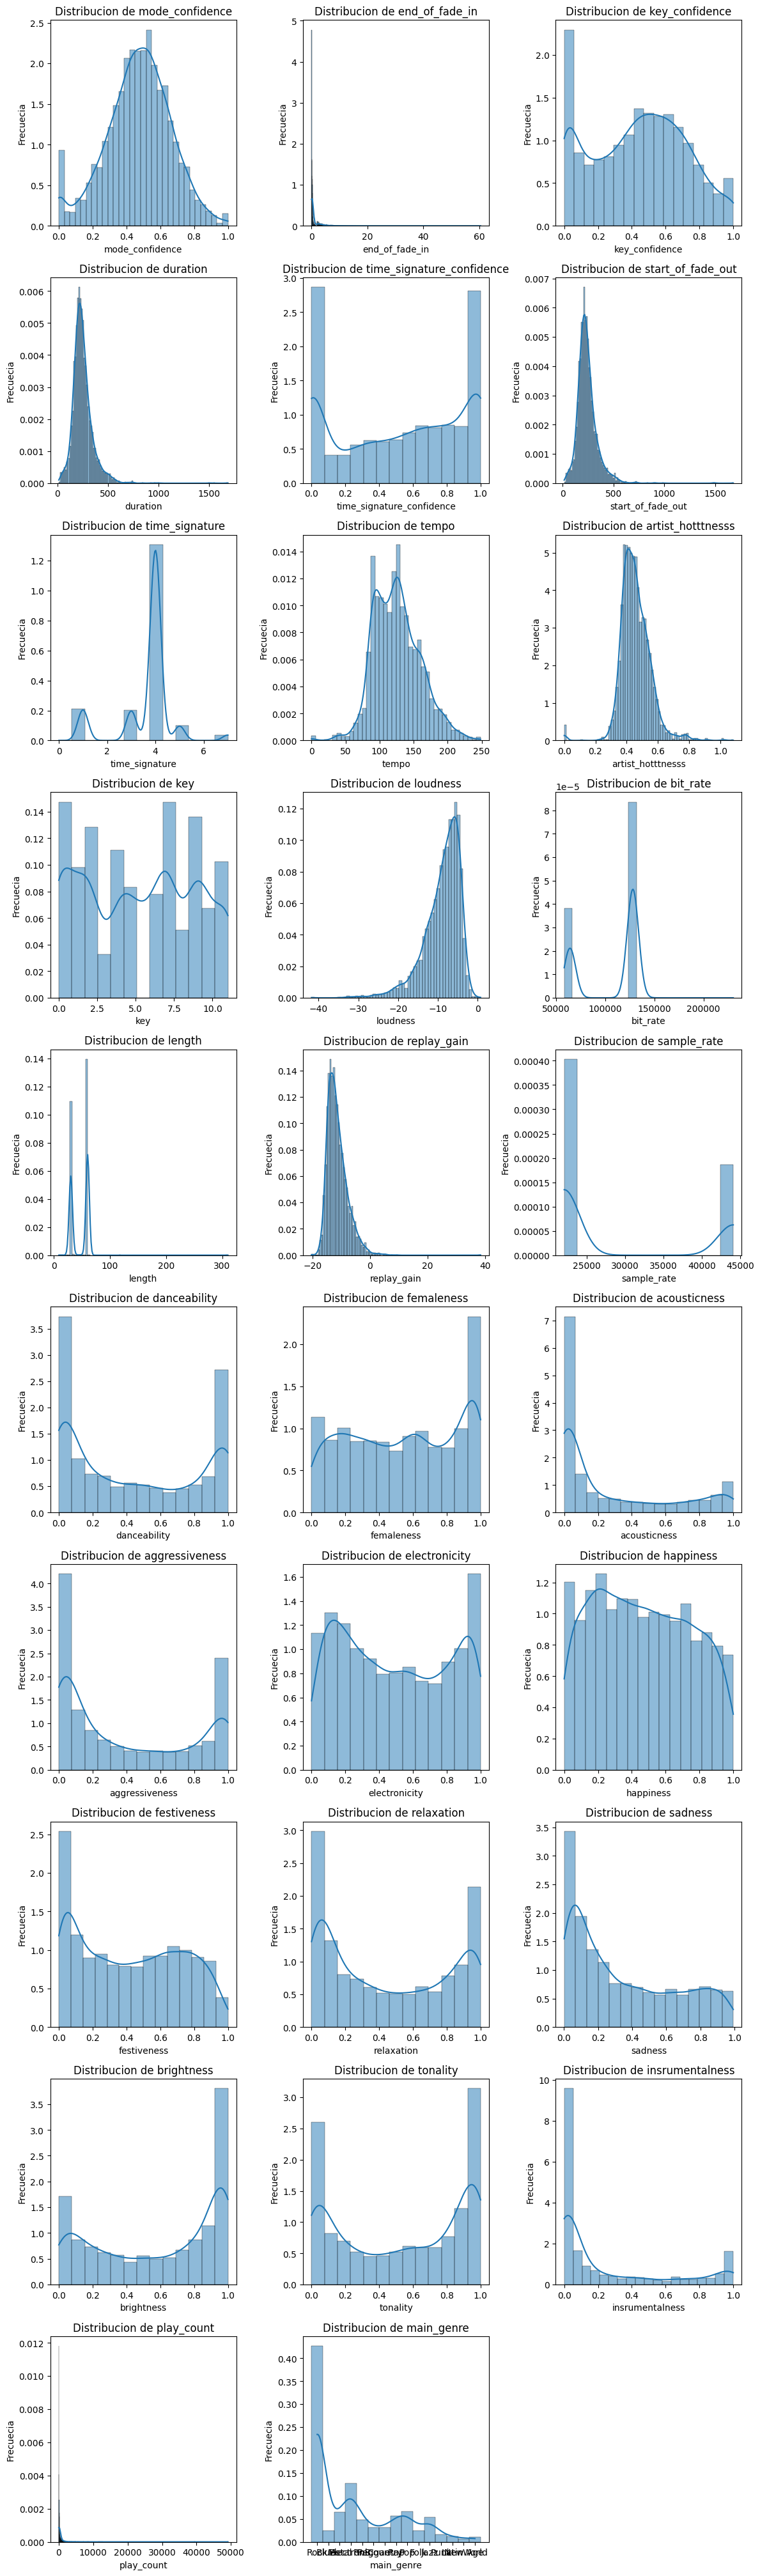

In [168]:
aux  = df_mer.columns.drop('track_id')
num_var = len(aux)
cols = 3
rows = (num_var // cols) + (num_var % cols)
plt.figure(figsize = (cols*4, rows*4))

for i, v in enumerate(aux, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_mer[v], kde = True, stat = 'density', linewidth = 0.25 )
    plt.plot(linewidth = 2)
    plt.title(f'Distribucion de {v}')
    plt.xlabel(v)
    plt.ylabel('Frecuecia')

plt.tight_layout()
plt.show()
    

OUTLIERS: end_of_fade_in, Duration, start_of_fade_out, loudness, replay_gain

Categoricas: time_signature, Key, bit_rate, length, sample_rate, main_genre


In [169]:
df_mer.describe([0.01, 0.25, 0.5, 0.75, 0.99])

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count
count,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3.330000e+03,3.330000e+03,3330.000000,3330.000000,3330.000000,3.330000e+03,3330.000000,3330.000000
mean,0.471971,0.911983,0.439054,250.537805,0.527278,240.870660,3.663363,125.800729,0.456388,5.279880,-8.953480,108075.679580,46.855027,-11.358983,29023.153153,4.416050e-01,5.431135e-01,2.743777e-01,4.008949e-01,0.494576,4.660381e-01,4.225352e-01,0.455529,0.349852,0.589916,5.363020e-01,0.246328,467.716817
std,0.191614,2.205328,0.276908,103.604439,0.371293,101.263597,1.119964,34.270209,0.095505,3.588438,4.577903,29865.628926,15.614642,3.570724,10254.412188,3.834576e-01,3.203668e-01,3.415280e-01,3.808397e-01,0.314047,2.817952e-01,3.019056e-01,0.361275,0.303856,0.361049,3.738967e-01,0.340768,1878.904170
min,0.000000,0.000000,0.000000,14.863220,0.000000,14.863000,0.000000,0.000000,0.000000,0.000000,-41.752000,58145.000000,8.672630,-20.352661,22050.000000,3.000001e-14,7.190201e-11,4.062316e-12,3.000001e-14,0.000013,6.147993e-10,2.580266e-07,0.000736,0.001810,0.000093,3.000001e-14,0.000002,1.000000
1%,0.000000,0.000000,0.000000,56.437095,0.000000,54.930080,1.000000,50.147350,0.286320,0.000000,-24.349580,64028.000000,29.884060,-16.897257,22050.000000,7.899662e-11,4.387197e-03,1.136856e-08,4.724511e-07,0.017470,5.149552e-03,1.316717e-03,0.004189,0.006606,0.002551,1.054249e-07,0.000054,1.000000
25%,0.356250,0.000000,0.204250,192.339142,0.148000,183.131250,4.000000,99.973250,0.396474,2.000000,-11.149500,64058.000000,30.040817,-13.891028,22050.000000,5.275831e-02,2.570719e-01,8.052085e-03,4.297031e-02,0.200964,2.218598e-01,1.287067e-01,0.091735,0.078084,0.223513,1.369093e-01,0.005410,17.000000
50%,0.479000,0.200000,0.455000,235.336690,0.578500,225.010000,4.000000,123.690500,0.447056,5.000000,-7.913000,128056.000000,60.029366,-12.122363,22050.000000,3.522282e-01,5.613017e-01,7.974853e-02,2.535777e-01,0.476828,4.547744e-01,4.126302e-01,0.390139,0.246993,0.688222,5.904834e-01,0.051168,64.000000
75%,0.600000,0.453000,0.648000,290.298325,0.879000,278.027250,4.000000,147.201500,0.509863,9.000000,-5.659000,128111.000000,60.029366,-9.572178,44100.000000,8.640895e-01,8.542334e-01,5.107173e-01,8.175596e-01,0.790406,7.047899e-01,6.879548e-01,0.829054,0.605832,0.947904,9.164003e-01,0.405115,251.750000
99%,0.904130,9.202540,1.000000,559.813818,1.000000,542.902030,7.000000,216.406170,0.768767,11.000000,-2.692060,128111.000000,60.133854,-0.689969,44100.000000,9.999987e-01,9.991403e-01,9.947895e-01,9.999409e-01,0.996431,9.884020e-01,9.658494e-01,0.996411,0.965459,1.000000,9.990849e-01,0.999998,7084.890000
max,1.000000,60.511000,1.000000,1686.569340,1.000000,1677.125000,7.000000,248.441000,1.082503,11.000000,0.709000,230322.000000,310.256317,38.401222,44100.000000,9.999999e-01,9.999861e-01,9.999401e-01,9.999999e-01,0.999930,9.999999e-01,9.999960e-01,0.999999,0.992247,1.000000,9.999726e-01,1.000000,49119.000000


<Axes: >

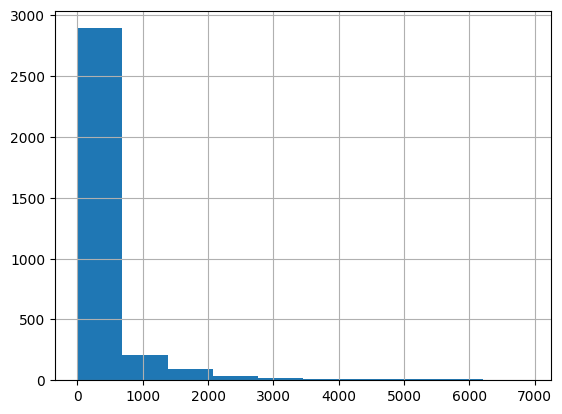

In [170]:
df_mer['play_count'][df_mer['play_count'] < 7000].hist()

In [171]:
len(df_mer[df_mer['play_count'] <= 7085])

3296

In [172]:
df_sin_out = df_mer[(df_mer['end_of_fade_in'] <= 9.202540) & 
                (df_mer['duration'] <= 559.813818) & 
                (df_mer['start_of_fade_out'] <= 542.902030) &
                (df_mer['loudness'] >= -24.349580) &
                (df_mer['replay_gain'] <= -0.689969) &
                (df_mer['play_count'] <= 7085)
                ].copy()

In [173]:
df_sin_out.isnull().sum()

track_id                     0
mode_confidence              0
end_of_fade_in               0
key_confidence               0
duration                     0
time_signature_confidence    0
start_of_fade_out            0
time_signature               0
tempo                        0
artist_hotttnesss            0
key                          0
loudness                     0
bit_rate                     0
length                       0
replay_gain                  0
sample_rate                  0
danceability                 0
femaleness                   0
acousticness                 0
aggressiveness               0
electronicity                0
happiness                    0
festiveness                  0
relaxation                   0
sadness                      0
brightness                   0
tonality                     0
insrumentalness              0
play_count                   0
main_genre                   0
dtype: int64

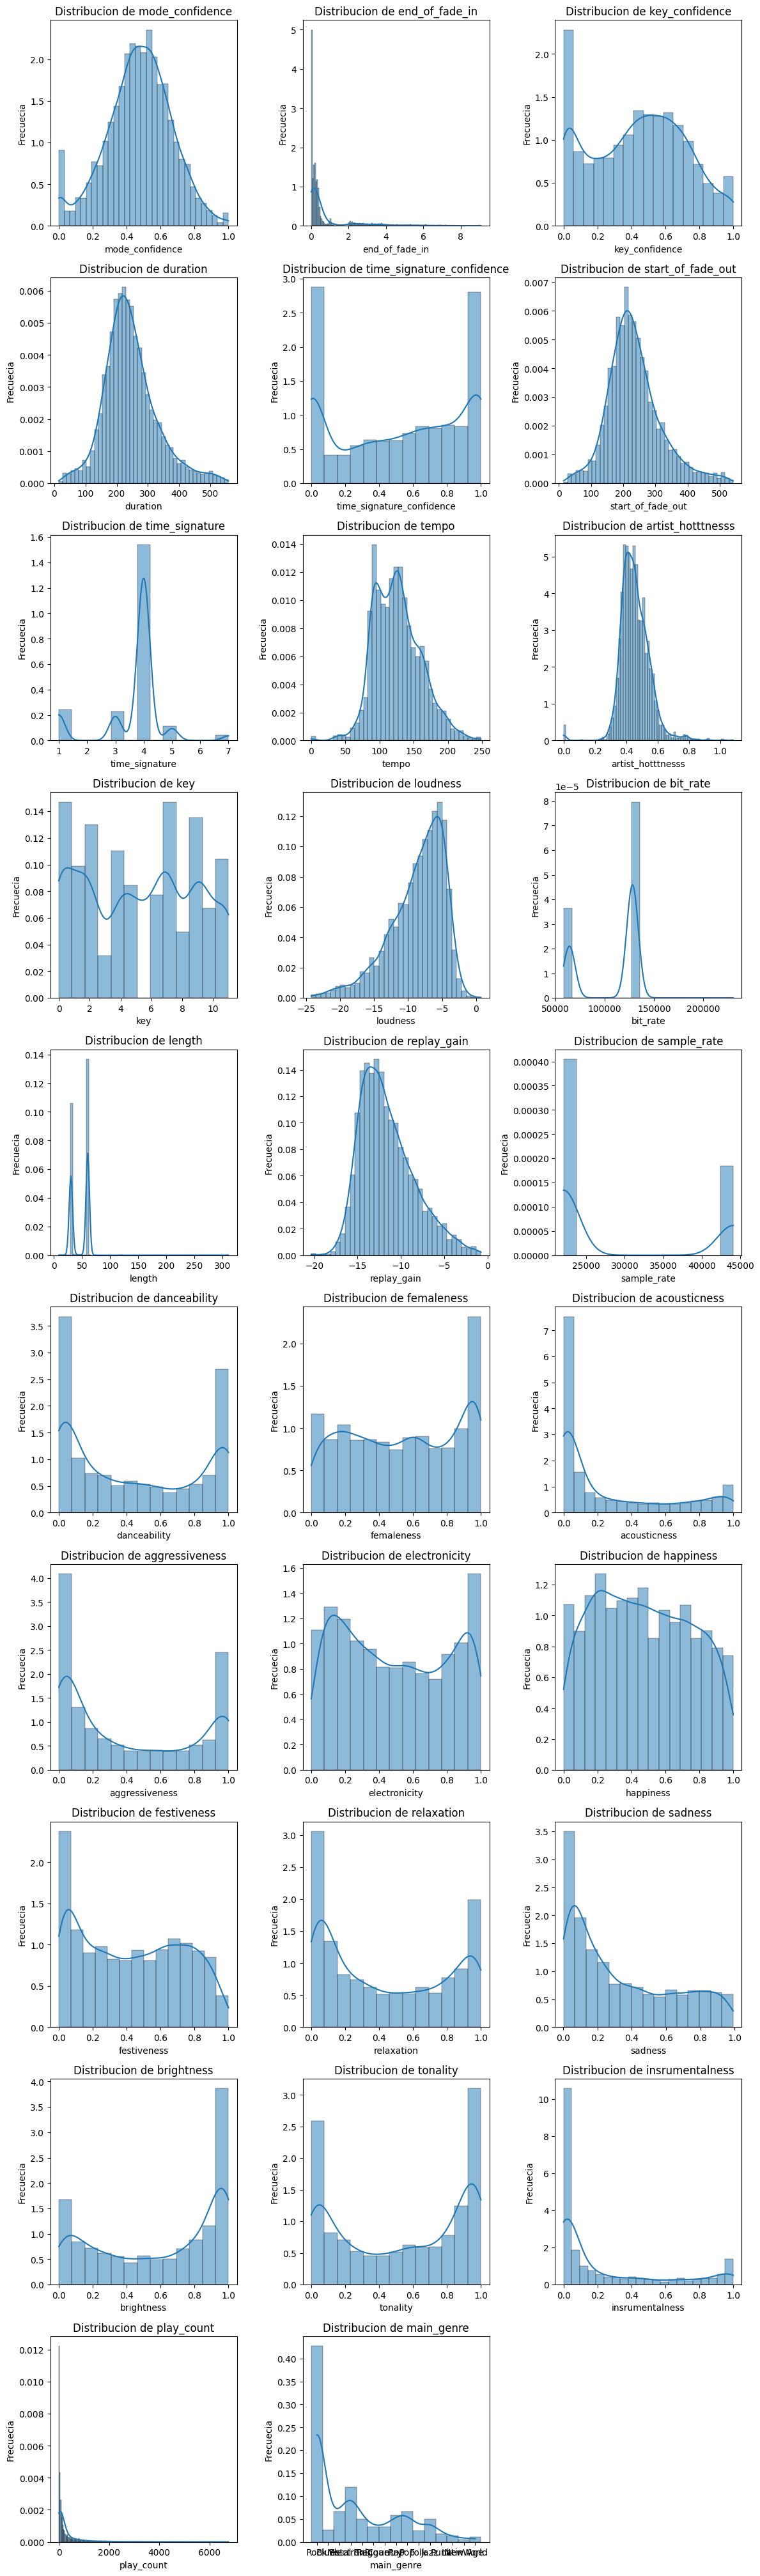

In [174]:
aux  = df_sin_out.columns.drop('track_id')
num_var = len(aux)
cols = 3
rows = (num_var // cols) + (num_var % cols)
plt.figure(figsize = (cols*4, rows*4))

for i, v in enumerate(aux, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_sin_out[v], kde = True, stat = 'density', linewidth = 0.25 )
    plt.plot(linewidth = 2)
    plt.title(f'Distribucion de {v}')
    plt.xlabel(v)
    plt.ylabel('Frecuecia')

plt.tight_layout()
plt.show()
    

## Ingenieria de Variables

In [175]:
df_sin_out

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,44100.0,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
7,TRAAEHK128F92C9C79,0.360,0.000,0.328,212.74077,0.424,204.516,4.0,166.349,0.000000,10.0,-6.469,128056.0,60.029366,-13.997978,22050.0,0.777133,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,15.0,Blues
8,TRAAFOH128E078BD7E,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,44100.0,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,40.0,Metal
11,TRAAIMO128F92EB778,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,22050.0,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,68.0,Rock
30,TRAAUEO128E0780CB9,0.523,0.000,0.532,241.52771,0.902,229.837,4.0,108.264,0.586433,10.0,-7.255,64059.0,60.029366,-10.828014,22050.0,0.649937,0.838906,0.000004,0.664901,0.935769,0.297491,0.830720,0.079845,0.068855,0.245584,0.030841,0.021891,2328.0,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,0.376,0.224,0.157,249.12934,0.265,242.196,4.0,141.267,0.396205,4.0,-13.431,128056.0,60.081612,-6.839115,22050.0,1.000000,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348,0.003443,0.016457,31.0,Reggae
24939,TRZZIJW128F930B20F,0.876,0.000,0.969,58.77506,0.000,58.775,1.0,120.005,0.386984,2.0,-20.022,128057.0,58.801609,-4.788458,22050.0,0.000004,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983,0.998203,0.990937,12.0,Rock
24942,TRZZMHR128F1490F28,0.424,4.458,0.307,403.95710,1.000,398.141,4.0,194.020,0.358851,10.0,-11.977,128111.0,30.040817,-7.450308,44100.0,0.768223,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229,0.789736,0.177510,14.0,Electronic
24944,TRZZOUK128F92E3480,0.529,0.000,0.599,213.47220,0.579,208.260,4.0,147.557,0.453524,10.0,-13.685,128111.0,30.040817,-6.247433,44100.0,0.267396,0.760838,0.048918,0.508864,0.788453,0.262665,0.684977,0.189497,0.187421,0.721574,0.874544,0.848592,86.0,Jazz


In [176]:
X = df_sin_out.drop(columns = ['play_count'])

In [177]:
y = df_sin_out['play_count']

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 666)

In [179]:
offset = X_train['end_of_fade_in'][X_train['end_of_fade_in'] > 0].min()
X_train['end_of_fade_in_log'] = np.log(X_train['end_of_fade_in']+ (offset))
X_test['end_of_fade_in_log'] = np.log(X_test['end_of_fade_in']+ (offset))

In [180]:
X_test.isnull().sum()

track_id                     0
mode_confidence              0
end_of_fade_in               0
key_confidence               0
duration                     0
time_signature_confidence    0
start_of_fade_out            0
time_signature               0
tempo                        0
artist_hotttnesss            0
key                          0
loudness                     0
bit_rate                     0
length                       0
replay_gain                  0
sample_rate                  0
danceability                 0
femaleness                   0
acousticness                 0
aggressiveness               0
electronicity                0
happiness                    0
festiveness                  0
relaxation                   0
sadness                      0
brightness                   0
tonality                     0
insrumentalness              0
main_genre                   0
end_of_fade_in_log           0
dtype: int64

<Axes: >

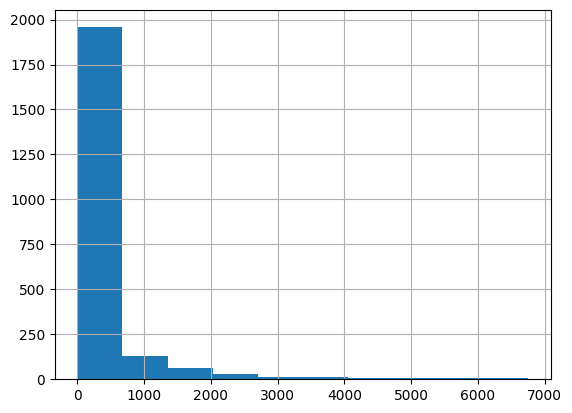

In [181]:
y_train.hist()

In [182]:
y_train = pd.cut(y_train, bins = [0,450,83256], labels = [0,1], include_lowest=True )
y_test = pd.cut(y_test, bins = [0,450,83256], labels = [0,1] , include_lowest=True)

In [183]:
len(y_test[y_test == 1])/len(y_test)

0.1720881427072403

<Axes: >

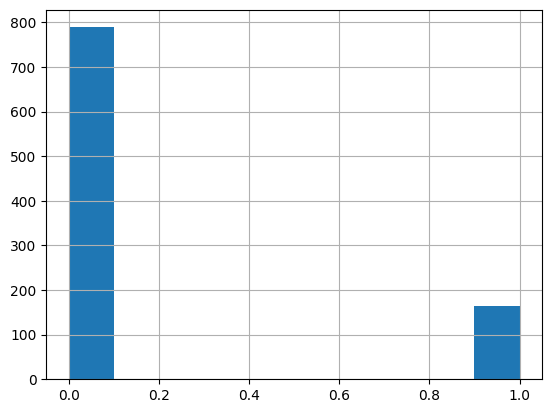

In [184]:
y_test.hist()

In [185]:
y_train.isnull().sum().sum()

np.int64(0)

In [186]:
y_test.isnull().sum().sum()

np.int64(0)

In [187]:
X_train = pd.get_dummies(X_train, columns = ['main_genre'], prefix = 'Genre')
X_test = pd.get_dummies(X_test, columns = ['main_genre'], prefix = 'Genre')

In [188]:
X_train.shape

(2223, 44)

In [189]:
X_test.shape

(953, 44)

Categoricas: time_signature, Key, bit_rate, length, sample_rate, main_genre

In [190]:
X_train['time_signature'].value_counts()

time_signature
4.0    1583
1.0     251
3.0     235
5.0     110
7.0      44
Name: count, dtype: int64

In [191]:
X_train['key'].value_counts()

key
0.0     295
7.0     274
9.0     245
2.0     235
4.0     218
11.0    201
1.0     172
5.0     162
6.0     139
10.0    119
8.0     100
3.0      63
Name: count, dtype: int64

In [192]:
X_train['bit_rate'].value_counts()

bit_rate
128056.0    661
128111.0    632
64028.0     307
64055.0     191
128000.0    171
           ... 
64097.0       1
128098.0      1
63813.0       1
128063.0      1
64106.0       1
Name: count, Length: 68, dtype: int64

In [193]:
X_train['length'].value_counts()

length
60.029366    856
30.040817    536
60.081612    255
30.040794    216
60.081635     99
            ... 
30.014694      1
52.715080      1
33.541225      1
29.727346      1
30.197552      1
Name: count, Length: 70, dtype: int64

In [194]:
X_train['sample_rate'].value_counts()

sample_rate
22050.0    1539
44100.0     683
24000.0       1
Name: count, dtype: int64

In [195]:
X_test['sample_rate'].value_counts()

sample_rate
22050.0    640
44100.0    313
Name: count, dtype: int64

In [196]:
#df_sin_out = pd.get_dummies(df_sin_out, columns = ['key'], prefix = 'key')
X_train = pd.get_dummies(X_train, columns = ['sample_rate'], prefix = 'sample_rate')
X_test = pd.get_dummies(X_test, columns = ['sample_rate'], prefix = 'sample_rate')

In [197]:
print(X_train.shape)
print(X_test.shape)

(2223, 46)
(953, 45)


In [198]:
X_train

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0
6476,TRGNOFL128EF34E4D5,0.725,0.083,0.619,222.24934,0.827,212.027,3.0,105.213,0.581506,4.0,-7.443,128111.0,30.090929,-14.031481,0.107706,0.616985,9.236637e-01,0.004915,0.200808,0.555832,0.009968,0.429439,0.955055,0.878378,0.978185,0.060109,-1.944911,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
19132,TRTUYQI128F429062E,0.519,0.000,0.127,195.29098,1.000,176.797,4.0,140.565,0.504925,6.0,-4.175,128000.0,30.040817,-13.773912,0.957242,0.294273,9.911291e-07,0.952882,0.826288,0.158375,0.902802,0.103402,0.045988,0.021075,0.010499,0.002023,-2.813411,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
22860,TRXTYYT128F9339262,0.588,0.281,0.613,176.19546,0.208,166.998,4.0,143.310,0.421570,6.0,-8.608,128056.0,60.029366,-10.934361,0.020422,0.319262,3.309695e-03,0.962631,0.098661,0.994624,0.398556,0.271488,0.157397,0.865975,0.654579,0.000409,-1.075873,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
17816,TRSKOFI128E079400B,0.438,0.432,0.579,172.45995,0.000,165.419,4.0,117.782,0.366539,5.0,-9.255,64028.0,60.029366,-10.144815,0.326738,0.464728,2.002779e-01,0.158497,0.473053,0.791096,0.265851,0.255756,0.526111,0.989773,0.733935,0.038985,-0.709277,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
8884,TRJBMJP12903CE433D,0.001,0.000,0.000,207.09832,1.000,202.559,4.0,128.257,0.398805,4.0,-5.388,128056.0,60.029366,-13.103502,0.000005,0.583253,1.447448e-02,0.817638,0.793512,0.482074,0.099766,0.470919,0.582972,0.746140,0.964893,0.021114,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,TRALQGQ128F427E682,0.354,0.000,0.378,202.37016,1.000,200.220,4.0,101.978,0.406329,6.0,-2.756,128000.0,60.081635,-14.997238,0.989953,0.996782,3.761870e-02,0.242321,0.899101,0.500000,0.860772,0.113721,0.437496,0.776979,0.784130,0.080626,-2.813411,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
22453,TRXIMOI128F14AEBC1,0.682,0.194,0.571,160.36526,0.827,152.352,4.0,129.997,0.436769,8.0,-9.976,64028.0,60.029366,-10.566040,0.388589,0.901439,2.911557e-01,0.062881,0.564256,0.398894,0.273733,0.300927,0.183220,0.511381,0.139482,0.050224,-1.370421,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
14984,TRPNIEV128F1464D46,0.476,0.165,0.691,370.12853,0.000,358.301,4.0,135.996,0.583910,4.0,-4.949,128111.0,30.040794,-15.086588,0.009765,0.284597,5.958047e-03,0.963351,0.015921,0.537150,0.143239,0.321405,0.048919,0.962684,0.572952,0.006742,-1.491655,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
14812,TRPITFB128F9303DB5,0.417,0.200,0.164,100.70159,0.000,94.883,1.0,134.708,0.475526,7.0,-8.008,128056.0,60.081612,-12.295338,0.104564,0.426789,2.563437e-02,0.709255,0.320729,0.480032,0.385054,0.151650,0.031099,0.381254,0.588095,0.664848,-1.347074,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


In [199]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=False)

In [200]:
print(X_train.shape)
print(X_test.shape)

(2223, 46)
(953, 46)


In [201]:
X_test

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0
7331,TRHLCPL128F92DEFDF,0.474,0.000,0.042,121.86077,0.000,121.861,4.0,167.000,0.402816,2.0,-10.949,128056.0,60.029366,-7.949957,0.087980,0.469522,3.358335e-02,0.426360,0.295088,0.943031,0.392114,0.016437,0.278153,0.927242,0.890419,0.134565,-2.813411,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False
16047,TRQOLTV128F932F314,0.761,0.000,0.984,263.26159,0.173,249.493,4.0,96.691,0.380136,0.0,-14.718,128056.0,60.029366,-8.551397,0.100189,0.924519,1.173962e-01,0.027049,0.665850,0.110180,0.012832,0.980625,0.151770,0.598268,0.827868,0.673505,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
15145,TRPRMHR128F9335AC4,0.547,0.653,0.611,123.27138,0.526,114.869,4.0,136.477,0.389272,10.0,-10.136,128056.0,60.029366,-10.783020,0.490025,0.048674,5.715933e-02,0.203515,0.406204,0.907504,0.446998,0.333502,0.526507,0.999999,0.336365,0.045555,-0.338274,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
1159,TRBERRB128F932D534,0.671,0.355,0.700,436.34893,0.501,428.884,4.0,95.201,0.462232,11.0,-19.510,128056.0,60.029366,-6.835384,0.083513,0.954482,9.205654e-01,0.067340,0.141870,0.103500,0.025519,0.997150,0.962185,0.337370,0.718252,0.147519,-0.879477,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
21467,TRWGRDY128F425C748,0.233,6.902,0.002,220.86485,0.934,205.247,7.0,126.900,0.411249,1.0,-12.826,128000.0,30.040817,-7.862789,0.995401,0.782937,3.398339e-01,0.406266,0.956745,0.745273,0.046491,0.865958,0.809051,0.000599,0.003696,0.732844,1.940467,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13526,TRNYMPM128E0793963,0.524,0.000,0.501,318.06649,1.000,304.071,3.0,95.110,0.635429,9.0,-12.861,64028.0,60.029366,-7.631550,0.108951,0.987078,6.694053e-01,0.031494,0.095206,0.334002,0.171883,0.263347,0.791991,0.730682,0.758548,0.000076,-2.813411,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
23289,TRYGFIR128F424A915,0.343,0.000,0.031,390.53016,1.000,373.435,3.0,98.580,0.347506,0.0,-9.693,128056.0,60.081612,-12.948097,0.050754,0.224100,8.163216e-03,0.660763,0.308587,0.291526,0.298800,0.254563,0.035012,0.696541,0.023835,0.032786,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
11043,TRLKDSX128E0781C69,0.358,0.000,0.356,186.87955,0.671,186.880,4.0,91.676,0.508678,1.0,-5.382,64056.0,60.029366,-12.442034,0.012136,0.318284,1.284434e-05,0.986374,0.762387,0.639216,0.858384,0.051677,0.017842,0.860218,0.661183,0.043785,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
13285,TRNSMEH128F428B6CD,0.734,0.305,0.738,425.56036,0.534,421.297,4.0,107.810,0.464244,7.0,-8.562,64055.0,30.040794,-11.237185,0.119501,0.200440,1.599267e-08,0.999830,0.918055,0.279620,0.976001,0.107034,0.006243,0.110467,0.005908,0.002441,-1.007858,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False


In [202]:
features = [
    'danceability', 'femaleness', 'acousticness', 'aggressiveness',
    'electronicity', 'happiness', 'festiveness', 'relaxation',
    'sadness', 'brightness'
]

# Valores absolutos de las diferencias de medias
for col in features:
    diff_abs = abs(
        X_train[col][y_train == 1].mean() -
        X_train[col][y_train == 0].mean()
    )
    print(f"{col:<20} {diff_abs:>10.4f}")

danceability             0.0322
femaleness               0.0193
acousticness             0.0195
aggressiveness           0.0113
electronicity            0.0043
happiness                0.0095
festiveness              0.0120
relaxation               0.0144
sadness                  0.0183
brightness               0.0394


In [203]:
# Valores reales de las diferencias de medias
for col in features:
    diff = (
        X_train[col][y_train == 1].mean() -
        X_train[col][y_train == 0].mean()
    )
    print(f"{col:<20} {diff:>10.4f}")

danceability             0.0322
femaleness              -0.0193
acousticness            -0.0195
aggressiveness           0.0113
electronicity           -0.0043
happiness                0.0095
festiveness              0.0120
relaxation              -0.0144
sadness                 -0.0183
brightness               0.0394


In [204]:
X_train.describe()

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2223.000000,2.223000e+03,2223.000000,2223.000000,2223.000000,2223.000000,2.223000e+03,2223.000000,2223.000000
mean,0.473878,0.755502,0.438216,245.314795,0.525652,235.711507,3.664417,126.566817,0.452077,5.250112,-8.717683,107130.011696,47.105213,-11.570779,4.435915e-01,5.409252e-01,2.643552e-01,4.080027e-01,0.493719,4.745055e-01,0.426959,0.449566,0.341132,0.597342,5.412313e-01,0.238494,-1.262008
std,0.192830,1.479986,0.280261,86.847318,0.372952,84.603327,1.112416,34.323143,0.093327,3.602613,4.080170,30193.978955,15.856486,3.134216,3.822515e-01,3.223287e-01,3.320208e-01,3.816849e-01,0.311855,2.781776e-01,0.299349,0.356098,0.297613,0.358040,3.726851e-01,0.333608,1.365618
min,0.000000,0.000000,0.000000,23.562000,0.000000,23.562000,1.000000,0.000000,0.000000,0.000000,-24.252000,58145.000000,20.950182,-20.352661,3.000001e-14,7.190201e-11,1.838101e-11,3.000001e-14,0.000013,8.993792e-07,0.000016,0.001049,0.001920,0.000217,3.000001e-14,0.000003,-2.813411
25%,0.357000,0.000000,0.198000,191.333425,0.143500,182.282000,4.000000,100.010500,0.395771,2.000000,-10.978000,64056.000000,30.040817,-13.905042,5.548467e-02,2.493691e-01,7.945898e-03,4.445358e-02,0.203140,2.368013e-01,0.138009,0.090672,0.075021,0.242107,1.405348e-01,0.005211,-2.813411
50%,0.477000,0.196000,0.449000,235.650160,0.576000,225.524000,4.000000,124.376000,0.442683,5.000000,-7.842000,128056.000000,60.029366,-12.178331,3.545047e-01,5.516065e-01,7.663341e-02,2.648748e-01,0.476859,4.614610e-01,0.417542,0.387004,0.242436,0.703276,6.068428e-01,0.050121,-1.362578
75%,0.604000,0.426000,0.656000,287.019955,0.878000,275.551500,4.000000,149.473000,0.504149,9.000000,-5.663500,128111.000000,60.029366,-9.763406,8.640791e-01,8.561139e-01,4.787092e-01,8.246888e-01,0.785477,7.092248e-01,0.687791,0.808817,0.583264,0.952204,9.181974e-01,0.390340,-0.721547
max,1.000000,9.009000,1.000000,557.896690,1.000000,541.164000,7.000000,245.935000,1.082503,11.000000,0.709000,230322.000000,310.256317,-0.762072,9.999999e-01,9.999861e-01,9.999401e-01,9.999999e-01,0.999709,9.999999e-01,0.999996,0.999999,0.987993,1.000000,9.999726e-01,1.000000,2.204862


In [205]:
X_train['danceability'][y_train == 1].mean()

np.float64(0.470328644110942)

In [206]:
X_train['brightness'][y_train == 1].mean().mean()

np.float64(0.6300623981014031)

In [207]:
X_train['aggressiveness'][y_train == 1].mean().mean()

np.float64(0.4173766076581605)

In [208]:
lst_feat = ['danceability', 'femaleness','acousticness','aggressiveness','electronicity','happiness','festiveness','relaxation','sadness',
           'brightness']

In [209]:
X_train[lst_feat]

,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness
6476,0.107706,0.616985,9.236637e-01,0.004915,0.200808,0.555832,0.009968,0.429439,0.955055,0.878378
19132,0.957242,0.294273,9.911291e-07,0.952882,0.826288,0.158375,0.902802,0.103402,0.045988,0.021075
22860,0.020422,0.319262,3.309695e-03,0.962631,0.098661,0.994624,0.398556,0.271488,0.157397,0.865975
17816,0.326738,0.464728,2.002779e-01,0.158497,0.473053,0.791096,0.265851,0.255756,0.526111,0.989773
8884,0.000005,0.583253,1.447448e-02,0.817638,0.793512,0.482074,0.099766,0.470919,0.582972,0.746140
...,...,...,...,...,...,...,...,...,...,...
455,0.989953,0.996782,3.761870e-02,0.242321,0.899101,0.500000,0.860772,0.113721,0.437496,0.776979
22453,0.388589,0.901439,2.911557e-01,0.062881,0.564256,0.398894,0.273733,0.300927,0.183220,0.511381
14984,0.009765,0.284597,5.958047e-03,0.963351,0.015921,0.537150,0.143239,0.321405,0.048919,0.962684
14812,0.104564,0.426789,2.563437e-02,0.709255,0.320729,0.480032,0.385054,0.151650,0.031099,0.381254


In [210]:
X_train[lst_feat][y_train == 0].idxmax(axis = 1).value_counts()

brightness        449
aggressiveness    379
danceability      306
femaleness        240
relaxation        194
electronicity      98
happiness          96
acousticness       50
festiveness        17
sadness            15
Name: count, dtype: int64

In [211]:
X_train[lst_feat][y_train == 1].idxmax(axis = 1).value_counts()

brightness        93
danceability      81
aggressiveness    71
femaleness        45
relaxation        38
happiness         16
electronicity     15
acousticness      13
festiveness        4
sadness            3
Name: count, dtype: int64

In [212]:
X_train['brightness*danceability'] = X_train['danceability'] * X_train['brightness']
X_test['brightness*danceability'] = X_test['danceability'] * X_test['brightness']

In [213]:
mean = X_train[lst_feat].mean(axis = 1).mean()

In [214]:
X_train['aggressiveness'].mean()

np.float64(0.40800266237904065)

In [215]:
mean

np.float64(0.44400985313206387)

In [216]:
X_train['danceability_upper_mean'] = X_train['danceability'].apply(lambda x: x > mean)
X_test['danceability_upper_mean'] = X_test['danceability'].apply(lambda x: x > mean)

In [217]:
X_train['brightness_upper_mean'] = X_train['brightness'].apply(lambda x: x > X_train['brightness'].mean())
X_test['brightness_upper_mean'] = X_test['brightness'].apply(lambda x: x > X_train['brightness'].mean())

In [218]:
X_train['aggressiveness_upper_mean'] = X_train['aggressiveness'].apply(lambda x: x > X_train['aggressiveness'].mean())
X_test['aggressiveness_upper_mean'] = X_test['aggressiveness'].apply(lambda x: x > X_train['aggressiveness'].mean())

In [219]:
X_train['key_confidence*key'] = X_train['key_confidence'] * X_train['key']
X_test['key_confidence*key'] = X_test['key_confidence'] * X_test['key']

<Axes: >

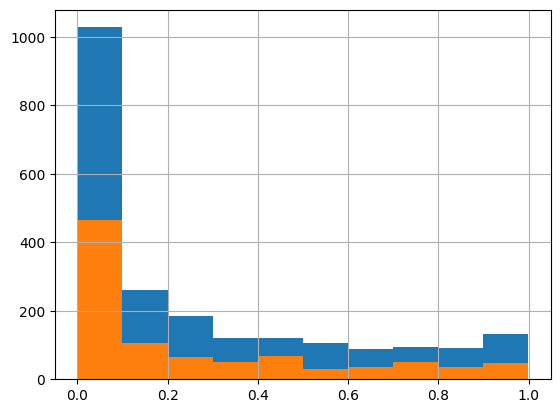

In [220]:
X_train['brightness*danceability'].hist()
X_test['brightness*danceability'].hist()

<Axes: >

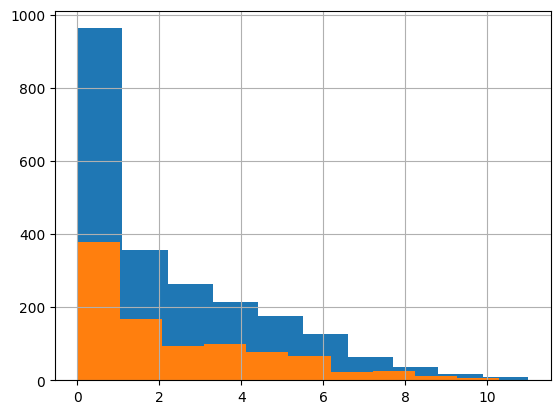

In [221]:
X_train['key_confidence*key'].hist()
X_test['key_confidence*key'].hist()

In [222]:
X_train['key_confidence*key'][X_train['key_confidence*key'] <= 0]

8884     0.0
2228     0.0
14919    0.0
6729     0.0
12268    0.0
        ... 
24678    0.0
5911     0.0
4099     0.0
1488     0.0
19055    0.0
Name: key_confidence*key, Length: 399, dtype: float64

In [223]:
offset = X_train['brightness*danceability'][X_train['brightness*danceability'] > 0].min()
X_train['brightness*danceability_log'] = np.log(X_train['brightness*danceability'] + offset)
X_test['brightness*danceability_log'] = np.log(X_test['brightness*danceability']+ (offset))

<Axes: >

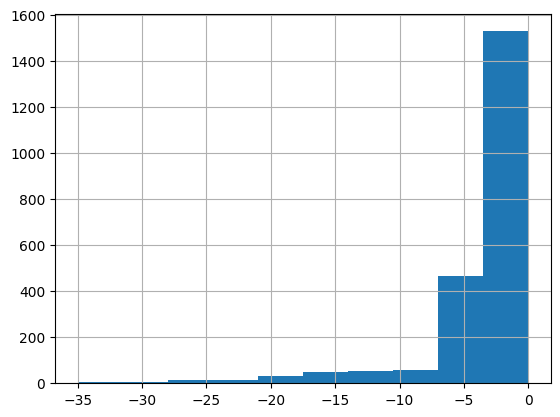

In [224]:
X_train['brightness*danceability_log'].hist()

In [225]:
X_train['time_signature*time_signature_confidence'] = X_train['time_signature'] * X_train['time_signature_confidence']
X_test['time_signature*time_signature_confidence'] = X_test['time_signature'] * X_test['time_signature_confidence']

In [226]:
X_train['loudness'][y_train == 1].mean()

np.float64(-8.024902374670186)

In [227]:
X_train['loudness'][y_train == 0].mean()

np.float64(-8.860071583514099)

In [228]:
X_train['loudness'].mean()

np.float64(-8.717683310841208)

In [229]:
X_train['loudness_upper_mean'] = X_train['loudness'].apply(lambda x: x > X_train['loudness'].mean())
X_test['loudness_upper_mean'] = X_test['loudness'].apply(lambda x: x > X_train['loudness'].mean())

In [230]:
X_train['danceability*loudness'] = X_train['danceability'] * X_train['loudness']
X_test['danceability*loudness'] = X_test['danceability'] * X_test['loudness']

In [231]:
for var in lst_feat:
    if var != 'danceability':
        X_train[f'danceability_{var}_ratio'] = X_train['danceability'] / X_train[var]
        X_test[f'danceability_{var}_ratio'] = X_test['danceability'] / X_test[var]

In [232]:
X_train

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio
6476,TRGNOFL128EF34E4D5,0.725,0.083,0.619,222.24934,0.827,212.027,3.0,105.213,0.581506,4.0,-7.443,128111.0,30.090929,-14.031481,0.107706,0.616985,9.236637e-01,0.004915,0.200808,0.555832,0.009968,0.429439,0.955055,0.878378,0.978185,0.060109,-1.944911,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0.094607,False,True,False,2.476,-2.358025,2.481,True,-0.801658,0.174569,0.116608,21.915452,0.536365,0.193775,10.805008,0.250807,0.112775,0.122620
19132,TRTUYQI128F429062E,0.519,0.000,0.127,195.29098,1.000,176.797,4.0,140.565,0.504925,6.0,-4.175,128000.0,30.040817,-13.773912,0.957242,0.294273,9.911291e-07,0.952882,0.826288,0.158375,0.902802,0.103402,0.045988,0.021075,0.010499,0.002023,-2.813411,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,0.020174,True,False,True,0.762,-3.903361,4.000,True,-3.996485,3.252904,965809.525857,1.004575,1.158485,6.044152,1.060301,9.257440,20.815113,45.420446
22860,TRXTYYT128F9339262,0.588,0.281,0.613,176.19546,0.208,166.998,4.0,143.310,0.421570,6.0,-8.608,128056.0,60.029366,-10.934361,0.020422,0.319262,3.309695e-03,0.962631,0.098661,0.994624,0.398556,0.271488,0.157397,0.865975,0.654579,0.000409,-1.075873,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,0.017685,False,True,True,3.678,-4.035028,0.832,True,-0.175795,0.063967,6.170443,0.021215,0.206995,0.020533,0.051241,0.075223,0.129750,0.023583
17816,TRSKOFI128E079400B,0.438,0.432,0.579,172.45995,0.000,165.419,4.0,117.782,0.366539,5.0,-9.255,64028.0,60.029366,-10.144815,0.326738,0.464728,2.002779e-01,0.158497,0.473053,0.791096,0.265851,0.255756,0.526111,0.989773,0.733935,0.038985,-0.709277,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,0.323397,False,True,False,2.895,-1.128876,0.000,False,-3.023961,0.703074,1.631424,2.061478,0.690700,0.413020,1.229026,1.277538,0.621044,0.330114
8884,TRJBMJP12903CE433D,0.001,0.000,0.000,207.09832,1.000,202.559,4.0,128.257,0.398805,4.0,-5.388,128056.0,60.029366,-13.103502,0.000005,0.583253,1.447448e-02,0.817638,0.793512,0.482074,0.099766,0.470919,0.582972,0.746140,0.964893,0.021114,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0.000004,False,True,True,0.000,-12.429888,4.000,True,-0.000029,0.000009,0.000370,0.000007,0.000007,0.000011,0.000054,0.000011,0.000009,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,TRALQGQ128F427E682,0.354,0.000,0.378,202.37016,1.000,200.220,4.0,101.978,0.406329,6.0,-2.756,128000.0,60.081635,-14.997238,0.989953,0

In [233]:
X_test

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio
7331,TRHLCPL128F92DEFDF,0.474,0.000,0.042,121.86077,0.000,121.861,4.0,167.000,0.402816,2.0,-10.949,128056.0,60.029366,-7.949957,0.087980,0.469522,3.358335e-02,0.426360,0.295088,0.943031,0.392114,0.016437,0.278153,0.927242,0.890419,0.134565,-2.813411,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,0.081578,False,True,True,0.084,-2.506190,0.000,False,-0.963289,0.187381,2.619740e+00,0.206350,0.298147,0.093295,0.224372,5.352533,0.316300,0.094883
16047,TRQOLTV128F932F314,0.761,0.000,0.984,263.26159,0.173,249.493,4.0,96.691,0.380136,0.0,-14.718,128056.0,60.029366,-8.551397,0.100189,0.924519,1.173962e-01,0.027049,0.665850,0.110180,0.012832,0.980625,0.151770,0.598268,0.827868,0.673505,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0.059940,False,True,False,0.000,-2.814411,0.692,False,-1.474586,0.108369,8.534287e-01,3.703982,0.150468,0.909327,7.807878,0.102169,0.660138,0.167466
15145,TRPRMHR128F9335AC4,0.547,0.653,0.611,123.27138,0.526,114.869,4.0,136.477,0.389272,10.0,-10.136,128056.0,60.029366,-10.783020,0.490025,0.048674,5.715933e-02,0.203515,0.406204,0.907504,0.446998,0.333502,0.526507,0.999999,0.336365,0.045555,-0.338274,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,0.490025,True,True,False,6.110,-0.713299,2.104,False,-4.966898,10.067508,8.572973e+00,2.407811,1.206352,0.539971,1.096260,1.469333,0.930710,0.490026
1159,TRBERRB128F932D534,0.671,0.355,0.700,436.34893,0.501,428.884,4.0,95.201,0.462232,11.0,-19.510,128056.0,60.029366,-6.835384,0.083513,0.954482,9.205654e-01,0.067340,0.141870,0.103500,0.025519,0.997150,0.962185,0.337370,0.718252,0.147519,-0.879477,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0.028175,False,False,False,7.700,-3.569324,2.004,False,-1.629344,0.087496,9.071955e-02,1.240165,0.588661,0.806891,3.272529,0.083752,0.086795,0.247542
21467,TRWGRDY128F425C748,0.233,6.902,0.002,220.86485,0.934,205.247,7.0,126.900,0.411249,1.0,-12.826,128000.0,30.040817,-7.862789,0.995401,0.782937,3.398339e-01,0.406266,0.956745,0.745273,0.046491,0.865958,0.809051,0.000599,0.003696,0.732844,1.940467,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0.000596,True,False,False,0.002,-7.425100,6.538,False,-12.767015,1.271369,2.929081e+00,2.450122,1.040404,1.335620,21.410658,1.149480,1.230331,1662.173817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13526,TRNYMPM128E0793963,0.524,0.000,0.501,318.06649,1.000,304.071,3.0,95.110,0.635429,9.0,-12.861,64028.0,60.0293

In [234]:
X_train.isnull().sum().sum()

np.int64(0)

In [235]:
X_test.isnull().sum().sum()

np.int64(0)

In [236]:
X_train = X_train.drop(columns = ['track_id'])
X_test = X_test.drop(columns = ['track_id'])

In [237]:
X_train.dtypes.value_counts()

float64    41
bool       22
Name: count, dtype: int64

In [238]:
X_test.dtypes.value_counts()

float64    41
bool       22
Name: count, dtype: int64

In [239]:
print(y_train.value_counts())
print(y_test.value_counts())

play_count
0    1844
1     379
Name: count, dtype: int64
play_count
0    789
1    164
Name: count, dtype: int64


In [240]:
X_train.shape

(2223, 63)

In [241]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2223 entries, 6476 to 17364
Data columns (total 63 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mode_confidence                           2223 non-null   float64
 1   end_of_fade_in                            2223 non-null   float64
 2   key_confidence                            2223 non-null   float64
 3   duration                                  2223 non-null   float64
 4   time_signature_confidence                 2223 non-null   float64
 5   start_of_fade_out                         2223 non-null   float64
 6   time_signature                            2223 non-null   float64
 7   tempo                                     2223 non-null   float64
 8   artist_hotttnesss                         2223 non-null   float64
 9   key                                       2223 non-null   float64
 10  loudness                             

In [244]:
lst_continuas = X_train.select_dtypes(include='float64').columns

In [249]:
X_train, woe_mapping, columns_bests, bin_edges = woe_continuas_a_discretas_train(X_train, lst_continuas, y_train)

Procesando columna: mode_confidence
mode_confidence: Best IV = 0.1263, Best K = 7
Procesando columna: end_of_fade_in
end_of_fade_in: Best IV = 0.1778, Best K = 8
Procesando columna: key_confidence
key_confidence: Best IV = 0.1893, Best K = 8
Procesando columna: duration
duration: Best IV = 0.1027, Best K = 7
Procesando columna: time_signature_confidence
time_signature_confidence: Best IV = 0.0866, Best K = 8
Procesando columna: start_of_fade_out
start_of_fade_out: Best IV = 0.1031, Best K = 8
Procesando columna: time_signature
time_signature: Best IV = 0.1175, Best K = 5
Procesando columna: tempo
tempo: Best IV = 0.0940, Best K = 10
Procesando columna: artist_hotttnesss
artist_hotttnesss: Best IV = 0.0760, Best K = 9
Procesando columna: key
key: Best IV = 0.0298, Best K = 10
Procesando columna: loudness
loudness: Best IV = 0.1143, Best K = 7
Procesando columna: bit_rate
bit_rate: Best IV = 0.0022, Best K = 3
Procesando columna: length
length: Best IV = 0.0419, Best K = 8
Procesando col

In [250]:
X_test = woe_continuas_a_discretas_test(X_test, woe_mapping,bin_edges)

Transformando columna: mode_confidence
Transformando columna: end_of_fade_in
Transformando columna: key_confidence
Transformando columna: duration
Transformando columna: time_signature_confidence
Transformando columna: start_of_fade_out
Transformando columna: time_signature
Transformando columna: tempo
Transformando columna: artist_hotttnesss
Transformando columna: key
Transformando columna: loudness
Transformando columna: bit_rate
Transformando columna: length
Transformando columna: replay_gain
Transformando columna: danceability
Transformando columna: femaleness
Transformando columna: acousticness
Transformando columna: aggressiveness
Transformando columna: electronicity
Transformando columna: happiness
Transformando columna: festiveness
Transformando columna: relaxation
Transformando columna: sadness
Transformando columna: brightness
Transformando columna: tonality
Transformando columna: insrumentalness
Transformando columna: end_of_fade_in_log
Transformando columna: brightness*danc

In [260]:
X_train

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio,W_mode_confidence,W_end_of_fade_in,W_key_confidence,W_duration,W_time_signature_confidence,W_start_of_fade_out,W_time_signature,W_tempo,W_artist_hotttnesss,W_key,W_loudness,W_bit_rate,W_length,W_replay_gain,W_danceability,W_femaleness,W_acousticness,W_aggressiveness,W_electronicity,W_happiness,W_festiveness,W_relaxation,W_sadness,W_brightness,W_tonality,W_insrumentalness,W_end_of_fade_in_log,W_brightness*danceability,W_key_confidence*key,W_brightness*danceability_log,W_time_signature*time_signature_confidence,W_danceability*loudness,W_danceability_femaleness_ratio,W_danceability_acousticness_ratio,W_danceability_aggressiveness_ratio,W_danceability_electronicity_ratio,W_danceability_happiness_ratio,W_danceability_festiveness_ratio,W_danceability_relaxation_ratio,W_danceability_sadness_ratio,W_danceability_brightness_ratio
6476,0.725,0.083,0.619,222.24934,0.827,212.027,3.0,105.213,0.581506,4.0,-7.443,128111.0,30.090929,-14.031481,0.107706,0.616985,9.236637e-01,0.004915,0.200808,0.555832,0.009968,0.429439,0.955055,0.878378,0.978185,0.060109,-1.944911,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0.094607,False,True,False,2.476,-2.358025,2.481,True,-0.801658,0.174569,0.116608,21.915452,0.536365,0.193775,10.805008,0.250807,0.112775,0.122620,14.872412,-0.014978,-0.195862,0.041466,1.091992,-0.009760,-0.078079,0.188550,-0.392572,0.497285,0.167044,0.07814,0.152445,0.049261,-0.121754,15.229087,-0.552537,-0.354927,-0.437024,0.363754,-0.247155,0.209603,-0.329393,-0.024012,0.209603,-0.176814,14.025114,0.038978,-0.227611,-0.049908,0.363754,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288
19132,0.519,0.000,0.127,195.29098,1.000,176.797,4.0,140.565,0.504925,6.0,-4.175,128000.0,30.040817,-13.773912,0.957242,0.294273,9.911291e-07,0.952882,0.826288,0.158375,0.902802,0.103402,0.045988,0.021075,0.010499,0.002023,-2.813411,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,0.020174,True,False,True,0.762,-3.903361,4.000,True,-3.996485,3.252904,965809.525857,1.004575,1.158485,6.044152,1.060301,9.257440,20.815113,45.420446,-0.216915,-0.014978,-0.247155,0.041466,0.454726,-0.009760,0.011152,-0.273823,-0.392572,0.091820,-0.371066,0.07814,0.152445,0.049261,-0.171169,0.557910,-0.111980,0.334766,-0.260401,-0.378184,-0.195862,-0.195862,-0.006620,0.167043,0.027282,-0.176814,-0.507642,0.038978,0.318803,-0.049908,0.460918,-0.371066,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288
22860,0.588,0.281,0.613,176.19546,0.208,166.998,4.0,143.310,0.421570,6.0,-8.608,128056.0,60.029366,-10.934361,0.020422,0.319262,3.309695e-03,0.962631,0.098661,0.994624,0.398556,0.271488,0.157397,0.865975,0.654579,0.000409,-1.075873,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,

In [254]:
X_test.isnull().sum().sum()

np.int64(0)

In [258]:
woe_var = [ 'W_' + i for i in X_train[lst_continuas].columns]

In [259]:
woe_var

['W_mode_confidence',
 'W_end_of_fade_in',
 'W_key_confidence',
 'W_duration',
 'W_time_signature_confidence',
 'W_start_of_fade_out',
 'W_time_signature',
 'W_tempo',
 'W_artist_hotttnesss',
 'W_key',
 'W_loudness',
 'W_bit_rate',
 'W_length',
 'W_replay_gain',
 'W_danceability',
 'W_femaleness',
 'W_acousticness',
 'W_aggressiveness',
 'W_electronicity',
 'W_happiness',
 'W_festiveness',
 'W_relaxation',
 'W_sadness',
 'W_brightness',
 'W_tonality',
 'W_insrumentalness',
 'W_end_of_fade_in_log',
 'W_brightness*danceability',
 'W_key_confidence*key',
 'W_brightness*danceability_log',
 'W_time_signature*time_signature_confidence',
 'W_danceability*loudness',
 'W_danceability_femaleness_ratio',
 'W_danceability_acousticness_ratio',
 'W_danceability_aggressiveness_ratio',
 'W_danceability_electronicity_ratio',
 'W_danceability_happiness_ratio',
 'W_danceability_festiveness_ratio',
 'W_danceability_relaxation_ratio',
 'W_danceability_sadness_ratio',
 'W_danceability_brightness_ratio']

In [262]:
lst_discretas = X_train.select_dtypes(include='bool').columns

In [263]:
lst_discretas

Index(['Genre_Blues', 'Genre_Country', 'Genre_Electronic', 'Genre_Folk',
       'Genre_Jazz', 'Genre_Latin', 'Genre_Metal', 'Genre_New Age',
       'Genre_Pop', 'Genre_Punk', 'Genre_Rap', 'Genre_Reggae', 'Genre_RnB',
       'Genre_Rock', 'Genre_World', 'sample_rate_22050.0',
       'sample_rate_24000.0', 'sample_rate_44100.0', 'danceability_upper_mean',
       'brightness_upper_mean', 'aggressiveness_upper_mean',
       'loudness_upper_mean'],
      dtype='object')

In [265]:
lst_model = list(woe_var) + list(lst_discretas)

In [267]:
X_train[lst_model]

,W_mode_confidence,W_end_of_fade_in,W_key_confidence,W_duration,W_time_signature_confidence,W_start_of_fade_out,W_time_signature,W_tempo,W_artist_hotttnesss,W_key,W_loudness,W_bit_rate,W_length,W_replay_gain,W_danceability,W_femaleness,W_acousticness,W_aggressiveness,W_electronicity,W_happiness,W_festiveness,W_relaxation,W_sadness,W_brightness,W_tonality,W_insrumentalness,W_end_of_fade_in_log,W_brightness*danceability,W_key_confidence*key,W_brightness*danceability_log,W_time_signature*time_signature_confidence,W_danceability*loudness,W_danceability_femaleness_ratio,W_danceability_acousticness_ratio,W_danceability_aggressiveness_ratio,W_danceability_electronicity_ratio,W_danceability_happiness_ratio,W_danceability_festiveness_ratio,W_danceability_relaxation_ratio,W_danceability_sadness_ratio,W_danceability_brightness_ratio,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,loudness_upper_mean
6476,14.872412,-0.014978,-0.195862,0.041466,1.091992,-0.009760,-0.078079,0.188550,-0.392572,0.497285,0.167044,0.07814,0.152445,0.049261,-0.121754,15.229087,-0.552537,-0.354927,-0.437024,0.363754,-0.247155,0.209603,-0.329393,-0.024012,0.209603,-0.176814,14.025114,0.038978,-0.227611,-0.049908,0.363754,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True
19132,-0.216915,-0.014978,-0.247155,0.041466,0.454726,-0.009760,0.011152,-0.273823,-0.392572,0.091820,-0.371066,0.07814,0.152445,0.049261,-0.171169,0.557910,-0.111980,0.334766,-0.260401,-0.378184,-0.195862,-0.195862,-0.006620,0.167043,0.027282,-0.176814,-0.507642,0.038978,0.318803,-0.049908,0.460918,-0.371066,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,True,True
22860,-0.483544,-0.014978,-0.195862,-0.282873,14.025114,-0.009760,0.011152,-0.273823,0.190911,0.091820,0.167044,0.07814,-0.087381,-0.195862,-0.121754,0.557910,-0.111980,0.334766,-0.195862,-0.115819,-0.024012,0.209603,-0.135237,-0.024012,-0.403501,-0.176814,0.586897,0.038978,-0.350013,-0.049908,-0.593545,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,True
17816,-0.216915,-0.014978,-0.195862,-0.282873,-0.763846,-0.009760,0.011152,0.188550,0.190911,0.027281,0.167044,-0.23223,-0.087381,0.122592,-0.282873,0.289646,0.209603,0.076072,0.669135,-0.483544,0.497285,0.209603,14.631250,-0.409436,0.363754,-0.176814,1.190432,-0.483544,-0.350013,-0.049908,-0.593545,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
8884,0.615067,-0.014978,0.669135,0.041466,0.454726,-0.009760,0.011152,-0.273823,0.190911,0.497285,-0.371066,0.07814,-0.087381,0.049261,-0.121754,15.229087,-0.111980,0.209603,-0.260401,-0.195862,-0.247155,0.209603,14.631250,0.027281,0.209603,-0.176814,-0.507642,0.038978,0.318803,13.842792,0.460918,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [268]:
X_test[lst_model]

,W_mode_confidence,W_end_of_fade_in,W_key_confidence,W_duration,W_time_signature_confidence,W_start_of_fade_out,W_time_signature,W_tempo,W_artist_hotttnesss,W_key,W_loudness,W_bit_rate,W_length,W_replay_gain,W_danceability,W_femaleness,W_acousticness,W_aggressiveness,W_electronicity,W_happiness,W_festiveness,W_relaxation,W_sadness,W_brightness,W_tonality,W_insrumentalness,W_end_of_fade_in_log,W_brightness*danceability,W_key_confidence*key,W_brightness*danceability_log,W_time_signature*time_signature_confidence,W_danceability*loudness,W_danceability_femaleness_ratio,W_danceability_acousticness_ratio,W_danceability_aggressiveness_ratio,W_danceability_electronicity_ratio,W_danceability_happiness_ratio,W_danceability_festiveness_ratio,W_danceability_relaxation_ratio,W_danceability_sadness_ratio,W_danceability_brightness_ratio,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,loudness_upper_mean
7331,-0.216915,-0.014978,0.669135,-0.282873,-0.763846,-0.301222,0.011152,0.528057,0.190911,0.027281,-0.282873,0.07814,-0.087381,0.432746,-0.121754,0.289646,-0.111980,14.430579,-1.043160,-0.115819,-0.024012,-0.362916,0.209603,-0.409436,0.209603,0.091820,-0.507642,0.038978,0.318803,-0.049908,-0.593545,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False
16047,14.872412,-0.014978,-0.195862,-0.065809,14.025114,0.345735,0.011152,-0.301222,0.190911,0.304913,0.209603,0.07814,-0.087381,0.432746,-0.121754,0.454726,1.056900,-0.354927,0.027281,-0.378184,-0.247155,0.122592,-0.135237,-0.041711,-0.953548,13.842792,-0.507642,0.038978,0.318803,-0.049908,-0.593545,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False
15145,-0.216915,-0.014978,-0.195862,-0.282873,0.363754,-0.301222,0.011152,-0.273823,0.190911,0.104243,-0.282873,0.07814,-0.087381,-0.195862,-0.483544,-0.195862,-0.111980,14.798304,0.651436,-0.115819,0.091820,14.631250,14.631250,-0.409436,-0.665866,-0.176814,1.190432,-0.041711,-0.378184,-0.049908,0.363754,-0.371066,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
1159,-0.483544,-0.014978,-0.935529,14.179265,0.363754,14.025114,0.011152,-0.301222,0.190911,0.104243,14.535940,0.07814,-0.087381,0.432746,-0.121754,0.454726,-0.552537,-0.354927,-0.437024,-0.378184,-0.247155,0.122592,-0.329393,14.718261,0.363754,0.091820,0.586897,0.038978,14.025114,-0.049908,0.363754,-0.011558,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
21467,0.720428,13.331967,0.669135,0.041466,0.454726,-0.009760,14.025114,-0.273823,0.190911,0.304913,-0.282873,0.07814,0.152445,0.432746,-0.171169,-0.601327,-0.329394,14.430579,0.465536,-0.483544,-0.247155,0.027281,0.289646,0.167043,0.027282,13.842792,14.312796,0.038978,0.318803,13.842792,13.619649,-0.665866,-0.028288,-0.039783,-0.028288,-0.028288,-0.028288,-0.028288,-0.024012,-0.057276,-0.028288,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Modelos

### Modelos sin escalar

In [321]:
selec_R = SelectKBest(score_func = f_classif, k = 20)
X_train_s = selec_R.fit_transform(X_train[lst_model], y_train)
X_test_s = selec_R.transform(X_test[lst_model])

In [322]:
Ran_For = RandomForestClassifier()
Ran_For.fit(X_train_s,y_train)

RandomForestClassifier()

In [323]:
cv_Ran_F = cross_val_score(Ran_For,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [324]:
print(cv_Ran_F)
print("ROC: %0.2f (+/- %0.2f)" % (cv_Ran_F.mean(), cv_Ran_F.std() * 2))

[0.67053559 0.68820425 0.69604907 0.69213029 0.69418248]
ROC: 0.69 (+/- 0.02)


In [325]:
y_pred = Ran_For.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5550673900275124


In [326]:
XGB = XGBClassifier()

In [327]:
XGB.fit(X_train_s, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [328]:
cv_XGB = cross_val_score(XGB,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [329]:
print(cv_XGB)
print("ROC: %0.2f (+/- %0.2f)" % (cv_XGB.mean(), cv_XGB.std() * 2))

[0.69034375 0.68037726 0.68731279 0.72311213 0.692972  ]
ROC: 0.69 (+/- 0.03)


In [330]:
y_pred = XGB.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5896666048409533


In [331]:
best_f = selec_R.get_support()

In [333]:
X_train[lst_model].columns[best_f]

Index(['W_key_confidence', 'W_tempo', 'W_artist_hotttnesss', 'W_loudness',
       'W_length', 'W_replay_gain', 'W_acousticness',
       'W_danceability_femaleness_ratio', 'W_danceability_electronicity_ratio',
       'Genre_Blues', 'Genre_Jazz', 'Genre_New Age', 'Genre_Pop',
       'Genre_World', 'sample_rate_22050.0', 'sample_rate_24000.0',
       'sample_rate_44100.0', 'danceability_upper_mean',
       'brightness_upper_mean', 'loudness_upper_mean'],
      dtype='object')

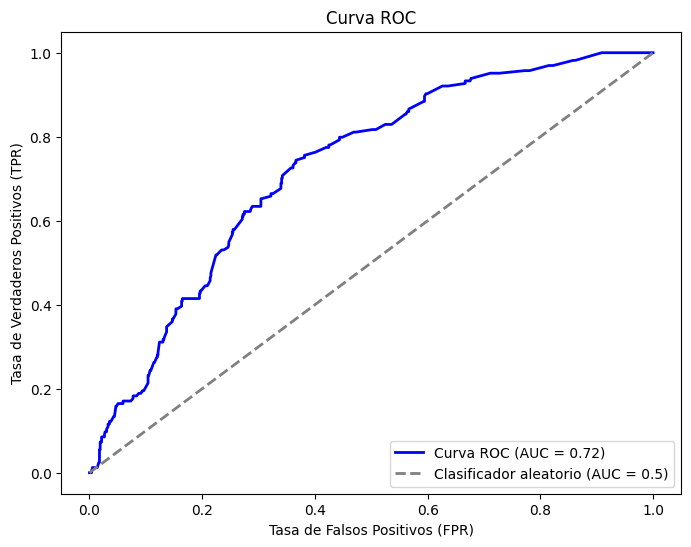

In [334]:
y_score = Ran_For.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [335]:
Rf_param = {
    
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}


In [336]:
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=Rf_param,
    n_iter=100,  
    cv=5, 
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1  
)


In [338]:
rf_random_search.fit(X_train_s, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [None, 5, 10, 15, 20, 25],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x745aa2917d70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x745aa2916b10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x745aa098f2f0>},
                   random_state=42, scoring='accuracy')

In [339]:
rf_random_search.best_score_

np.float64(0.8326541147889464)

In [340]:
y_pred = rf_random_search.best_estimator_.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5551524003833194


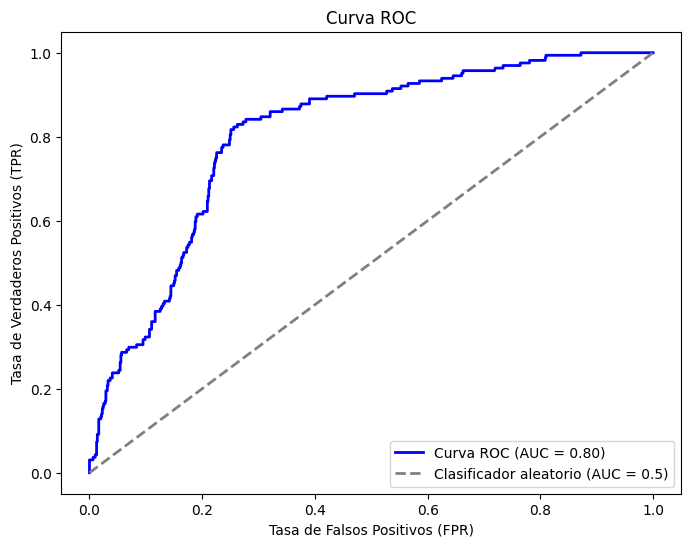

In [341]:
y_score = rf_random_search.best_estimator_.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [342]:
selec_Rl = SelectKBest(score_func = f_classif, k = 20)
X_train_s = selec_Rl.fit_transform(X_train[lst_model], y_train)
X_test_s = selec_Rl.transform(X_test[lst_model])

In [343]:
Log_Reg = LogisticRegression()

In [344]:
Log_Reg.fit(X_train_s, y_train)

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [345]:
cv_log_r = cross_val_score(Log_Reg,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

In [346]:
print(cv_log_r)
print("ROC: %0.2f (+/- %0.2f)" % (cv_log_r.mean(), cv_log_r.std() * 2))

[0.64085009 0.60627942 0.66880616 0.63032752 0.59392954]
ROC: 0.63 (+/- 0.05)


In [347]:
y_pred = Log_Reg.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5083928405823983


In [348]:
LDA = LinearDiscriminantAnalysis()

In [349]:
LDA.fit(X_train_s, y_train)

LinearDiscriminantAnalysis()

In [350]:
cv_LDA = cross_val_score(LDA,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [351]:
print(cv_LDA)
print("ROC: %0.2f (+/- %0.2f)" % (cv_LDA.mean(), cv_LDA.std() * 2))

[0.63122236 0.6035159  0.65489944 0.63213315 0.59927733]
ROC: 0.62 (+/- 0.04)


In [352]:
y_pred = LDA.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5494489783300874


In [353]:
Nv_Bayesian = GaussianNB()

In [354]:
Nv_Bayesian.fit(X_train_s, y_train)

GaussianNB()

In [355]:
cv_Nv = cross_val_score(Nv_Bayesian,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [356]:
print(cv_Nv)
print("ROC: %0.2f (+/- %0.2f)" % (cv_Nv.mean(), cv_Nv.std() * 2))

[0.66998288 0.62385894 0.67212238 0.62600114 0.61871725]
ROC: 0.64 (+/- 0.05)


In [357]:
y_pred = Nv_Bayesian.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5494489783300874


In [358]:
svc = SVC()

In [359]:
svc.fit(X_train_s, y_train)

SVC()

In [360]:
cv_svc = cross_val_score(svc,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [361]:
print(cv_svc)
print("ROC: %0.2f (+/- %0.2f)" % (cv_svc.mean(), cv_svc.std() * 2))

[0.63325489 0.64992512 0.63671374 0.60233124 0.68155375]
ROC: 0.64 (+/- 0.05)


In [362]:
y_pred = svc.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5060975609756098


In [363]:
param_grid_Nv_Bayesian = {
    'var_smoothing': np.logspace(-12, -6, 50)  # Rango en escala logarítmica
}


In [365]:
Bayesian_random_search = RandomizedSearchCV(
    estimator=GaussianNB(),
    param_distributions=param_grid_Nv_Bayesian,
    n_iter=100,  
    cv=5,  
    scoring='roc_auc',  
    random_state=666,
    n_jobs=-1 
)

In [366]:
Bayesian_random_search.fit(X_train_s, y_train)

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e-12, 1.32571137e-12, 1.75751062e-12, 2.32995181e-12,
       3.08884360e-12, 4.09491506e-12, 5.42867544e-12, 7.19685673e-12,
       9.54095476e-12, 1.26485522e-11, 1.67683294e-11, 2.22299648e-11,
       2.94705170e-11, 3.90693994e-11, 5.17947468e-11, 6.86648845e-1...
       2.68269580e-09, 3.55648031e-09, 4.71486636e-09, 6.25055193e-09,
       8.28642773e-09, 1.09854114e-08, 1.45634848e-08, 1.93069773e-08,
       2.55954792e-08, 3.39322177e-08, 4.49843267e-08, 5.96362332e-08,
       7.90604321e-08, 1.04811313e-07, 1.38949549e-07, 1.84206997e-07,
       2.44205309e-07, 3.23745754e-07, 4.29193426e-07, 5.68986603e-07,
       7.54312006e-07, 1.00000000e-06])},
                   random_state=666, scoring='roc_auc')

In [367]:
param_dist = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9],  # solo usado si solver es lsqr o eigen
    'store_covariance': [True, False],
    'tol': [1e-4, 1e-3, 1e-2]
}

In [368]:
LDA_random_search = RandomizedSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_distributions=param_dist,
    n_iter=20,      # número de combinaciones aleatorias a probar
    cv=5,           # cross-validation
    scoring='accuracy',  # o la métrica que te interese
    random_state=42,
    n_jobs=-1       # usa todos los cores disponibles
)

In [369]:
LDA_random_search.fit(X_train_s, y_train)

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/paul-h-roldan-hernandez/Di

RandomizedSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'shrinkage': [None, 'auto', 0.1, 0.3,
                                                      0.5, 0.7, 0.9],
                                        'solver': ['svd', 'lsqr', 'eigen'],
                                        'store_covariance': [True, False],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=42, scoring='accuracy')

In [370]:
Bayesian_random_search.best_score_

np.float64(0.6421436510741919)

In [371]:
LDA_random_search.best_score_

np.float64(0.8263569187164693)

In [374]:
y_pred = LDA_random_search.best_estimator_.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5531314723793627


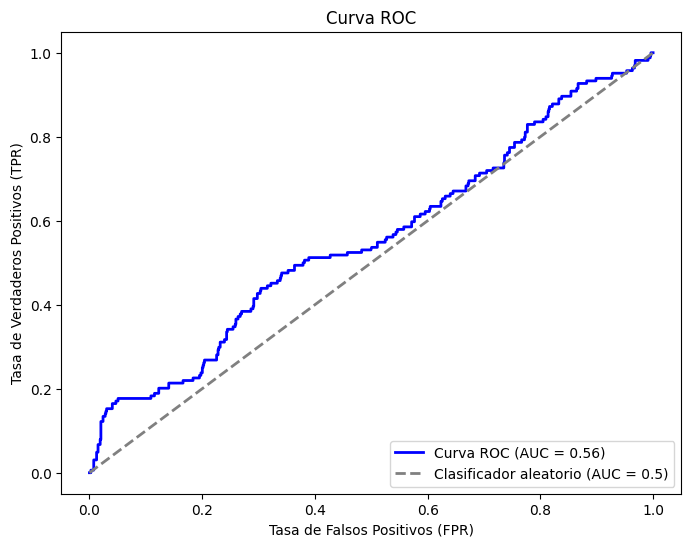

In [375]:
y_score = LDA_random_search.best_estimator_.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [377]:
y_pred = Bayesian_random_search.best_estimator_.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.557482456953847


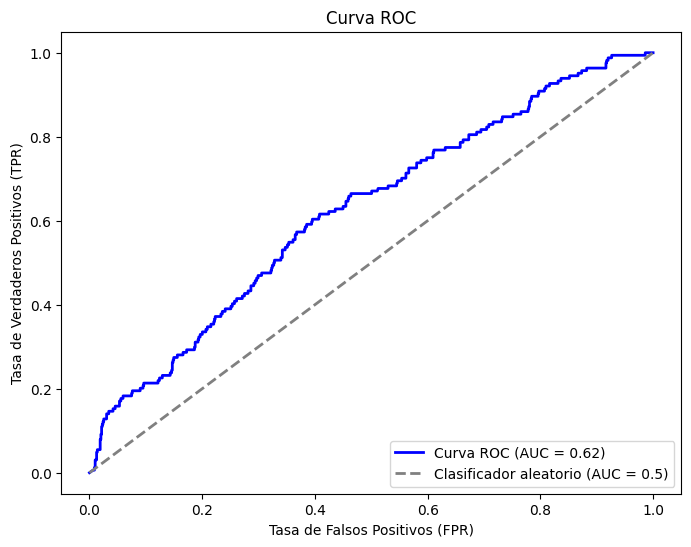

In [378]:
y_score = Bayesian_random_search.best_estimator_.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       789
           1       0.39      0.17      0.24       164

    accuracy                           0.81       953
   macro avg       0.62      0.56      0.56       953
weighted avg       0.77      0.81      0.78       953



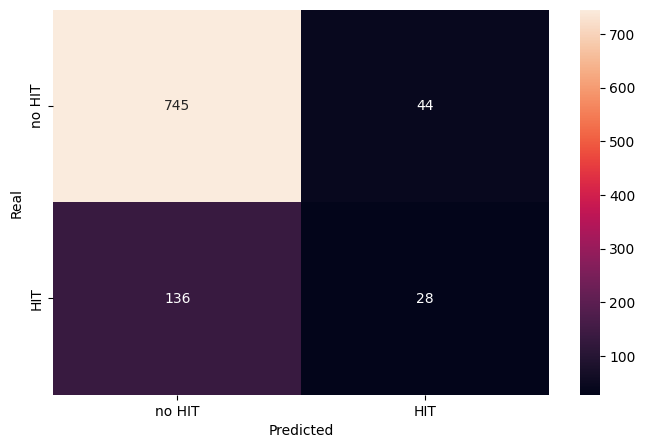

In [379]:
def metrics(real, predicted):
    print(classification_report(real, predicted))

    confusion_mat = confusion_matrix(real, predicted)
    plt.figure(figsize=(8, 5))
    sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=['no HIT', 'HIT'], yticklabels=['no HIT', 'HIT'])
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()

metrics(y_test, y_pred)

In [394]:
with open ('Modelo_Examen_2.pkl', 'wb') as file:
    pck.dump(logistic_random_search.best_estimator_, file)